In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from ydata_profiling import ProfileReport

In [2]:
from itertools import combinations
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import warnings
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

warnings.filterwarnings('ignore')

In [67]:
#import geopandas as gpd

#import folium 
#from folium import plugins
#from folium.plugins import HeatMap

#import geopy.geocoders
#from geopy.extra.rate_limiter import RateLimiter
#from geopy.geocoders import Bing

import reverse_geocoder as rg

In [6]:
df = pd.read_csv('/Users/jdapeman/Documents/Flatiron/Kings_C_PROJECT/test_cleaned.csv')

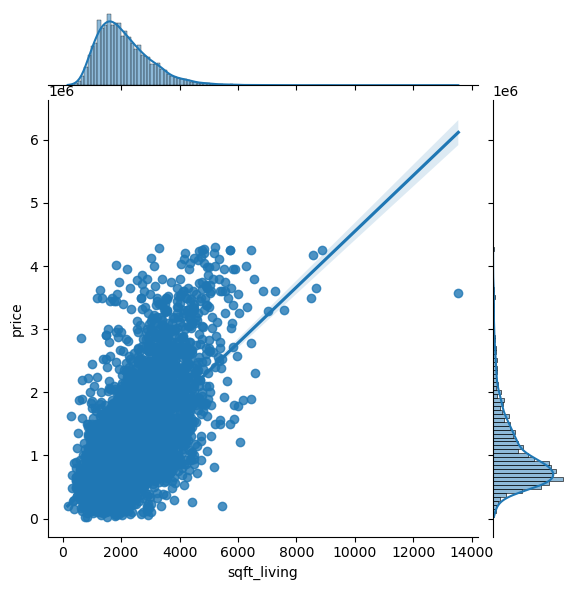

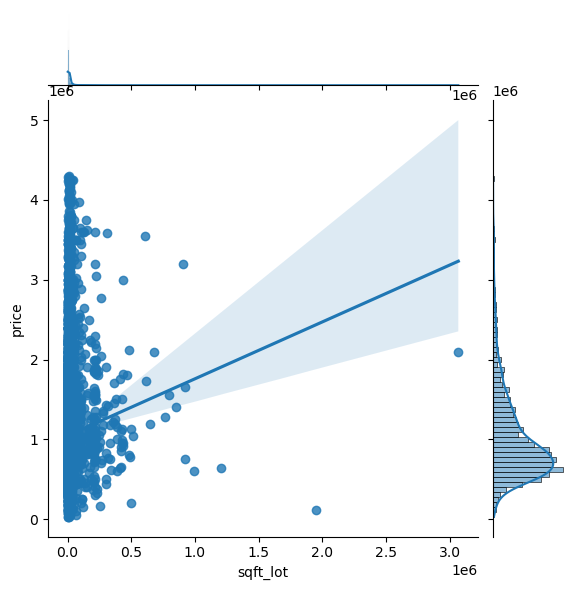

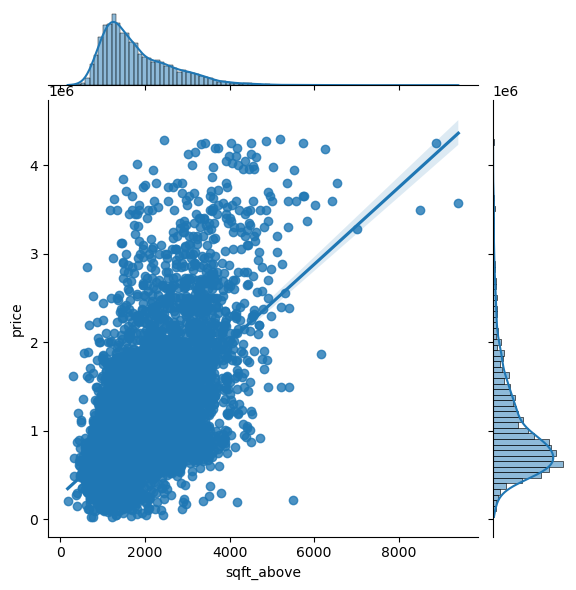

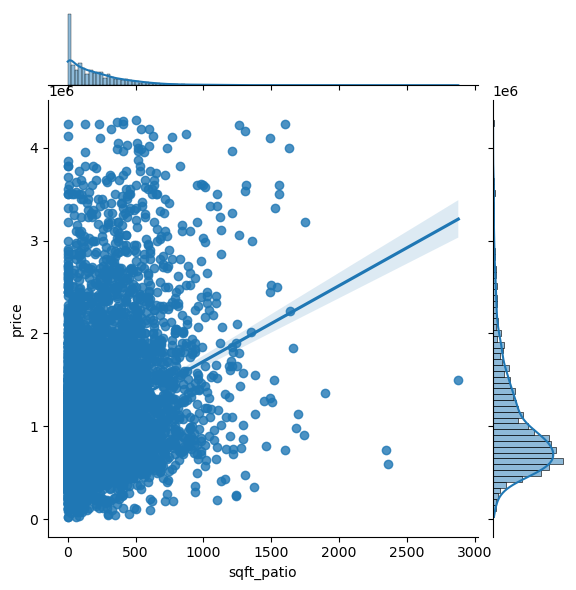

In [7]:
# We want to look at linearity of some select features vs our target variable, price
cont_feat = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_patio']


#  Plot jointplots
for feature in cont_feat:
    sns.jointplot(x = df[feature], y = df['price'], kind = 'reg')

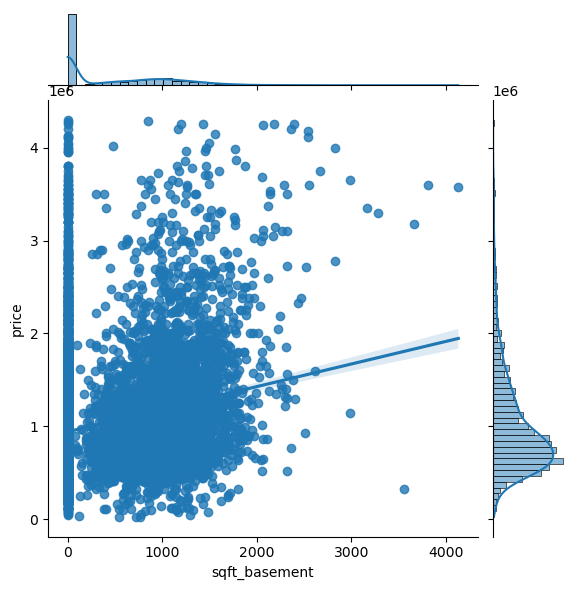

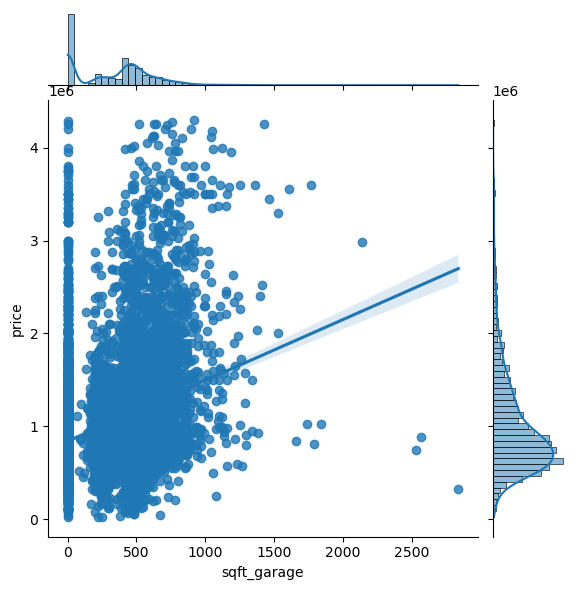

In [8]:
# let's look at linearity for some different continuous features

cont_feat_2 = ['sqft_basement', 'sqft_garage']


#  Plot jointplots
for feature in cont_feat_2:
    sns.jointplot(x = df[feature], y = df['price'], kind = 'reg')

In [9]:
# we're getting really screwed up data due to the zeroes in the basement sq foot. we are unsure whether to leave this
# column and calculate its mean, or create a new column of the mean with just those places that have a basement

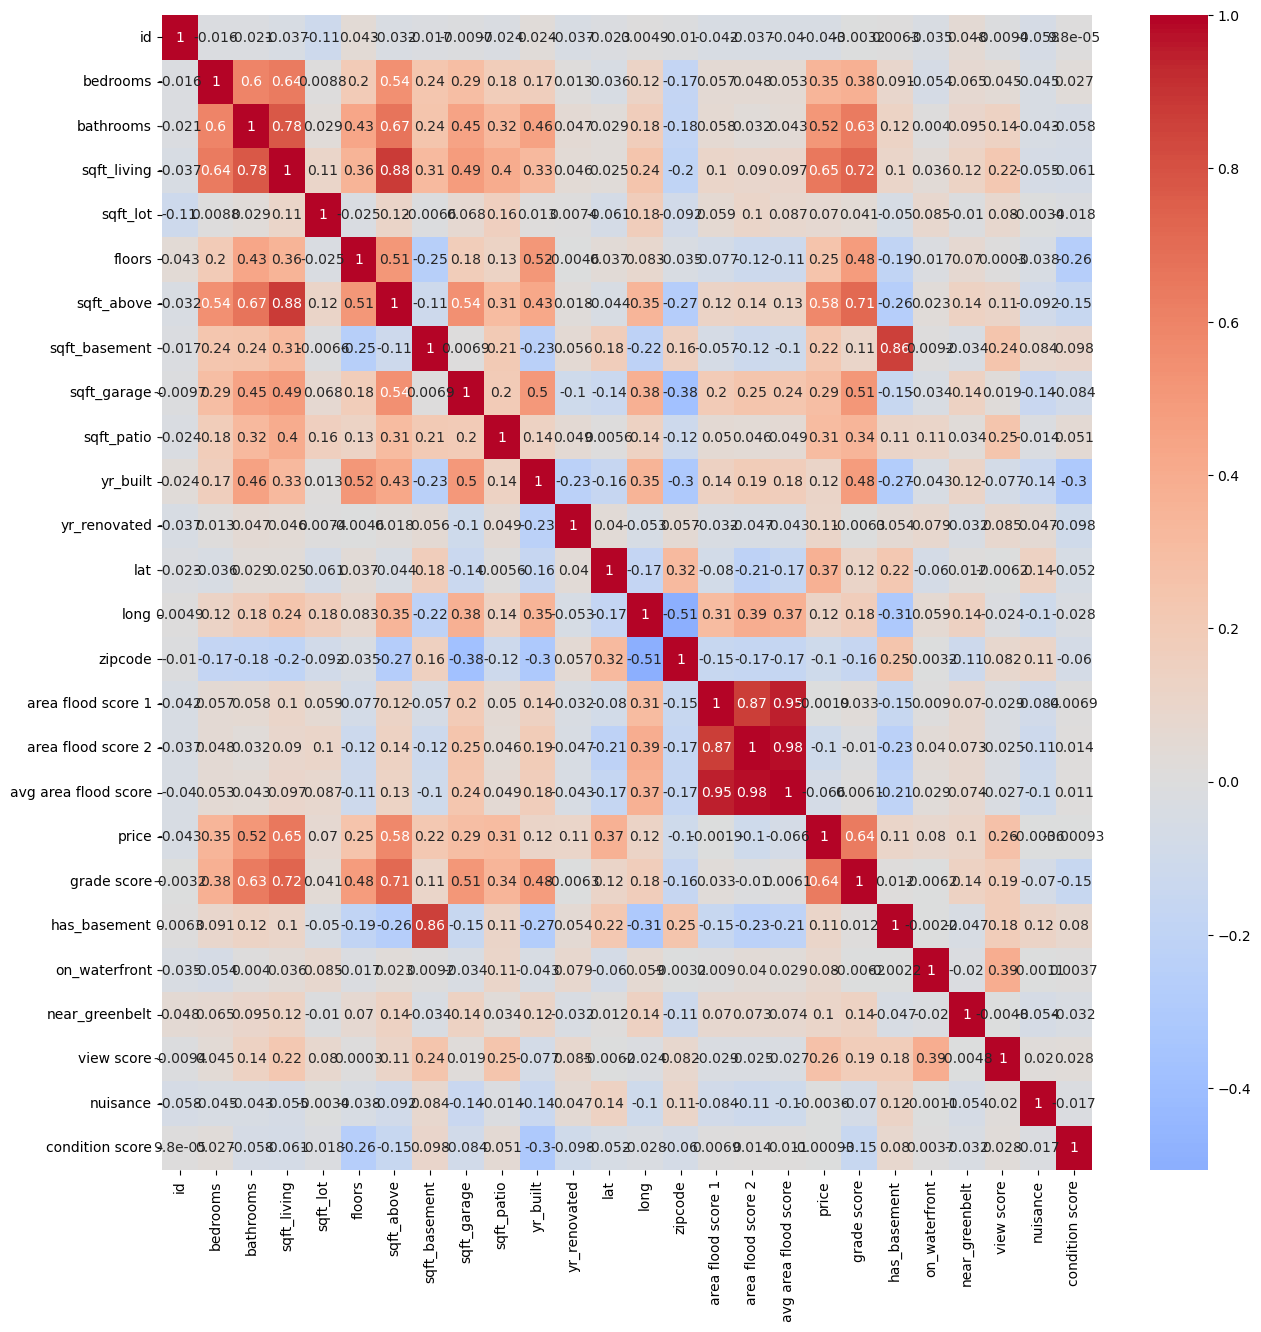

In [10]:
# done with continuous variables, so let's look again at multicollinearity using heatmaps

corr = df.corr()

# Plot heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr, center = 0, annot = True, cmap = 'coolwarm')
plt.show()

In [11]:
# gonna drop sq_basement, since it is so highly correlated with "has_basement" AND so few have basements that it
# really skews the mean

In [12]:
df.drop(labels='sqft_basement', axis=1, inplace=True)

In [13]:
# sqft_above is also fairly strongly correlated AND isn't super-relevant for our purposes
df.drop(labels='sqft_above', axis=1, inplace=True)

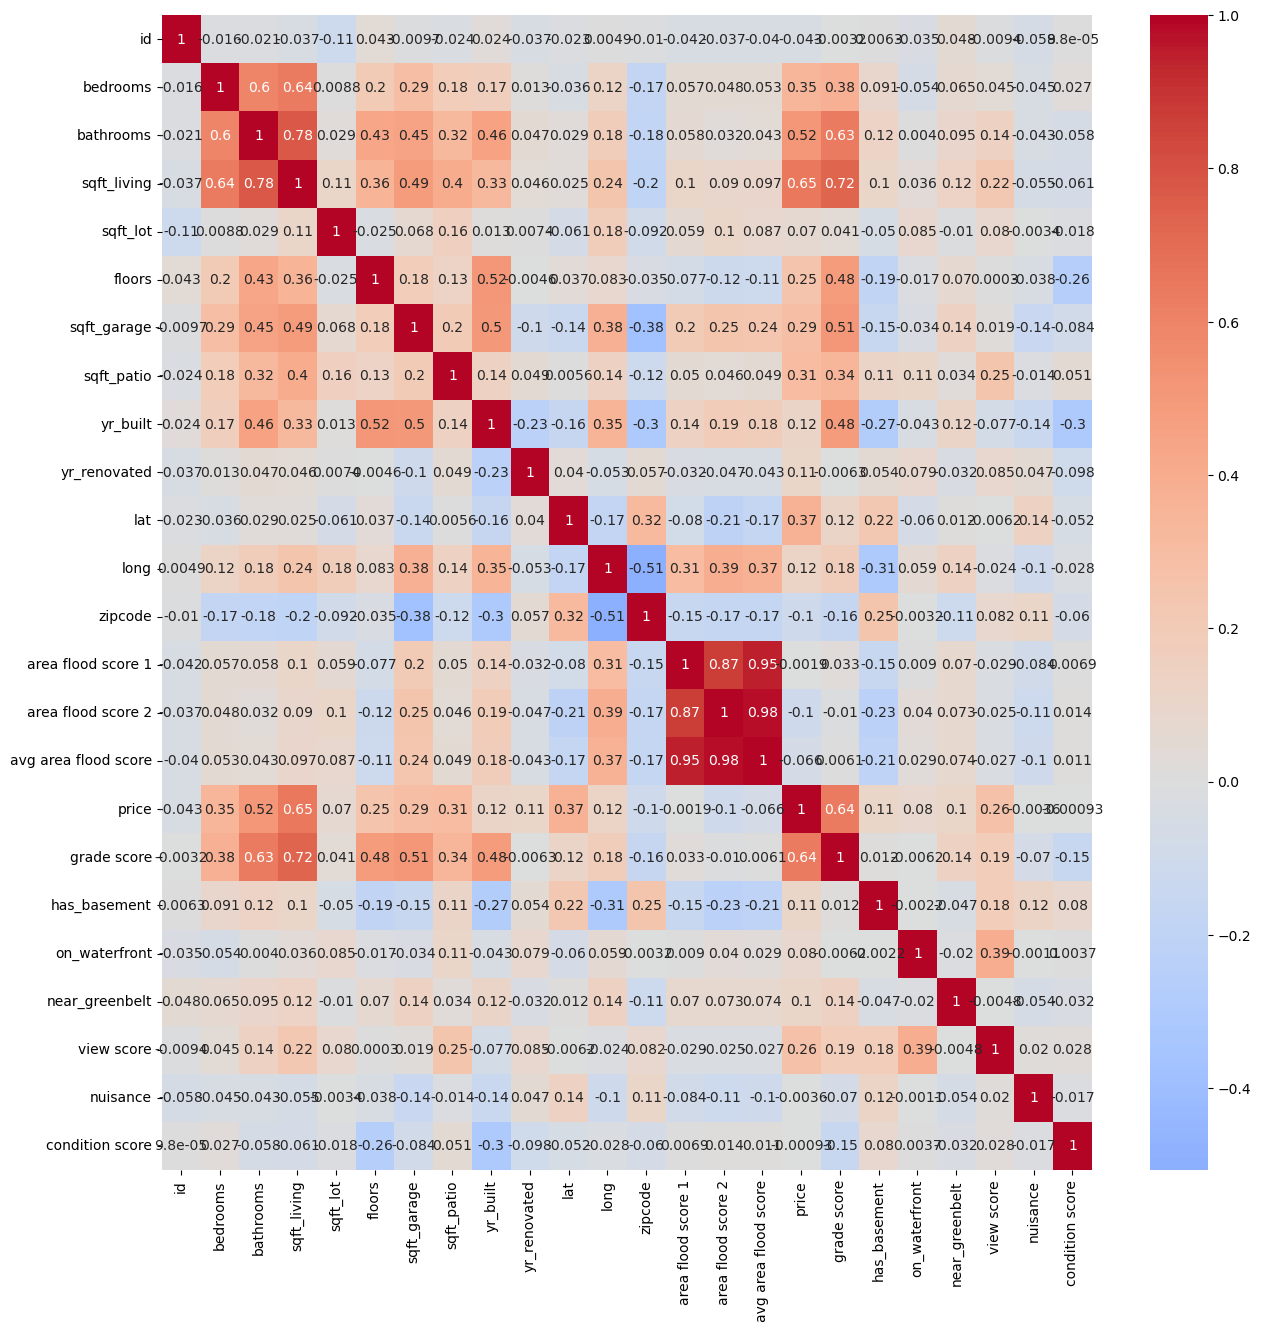

In [14]:
#let's get a new heatmap

new_corr = df.corr()

# Plot heatmap
plt.figure(figsize = (15,15))
sns.heatmap(new_corr, center = 0, annot = True, cmap = 'coolwarm')
plt.show()

In [15]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# https://www.statology.org/how-to-calculate-vif-in-python/

y, X = dmatrices('sqft_living ~ bedrooms+bathrooms', data=df, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,13.924592,Intercept
1,1.553190,bedrooms
2,1.553190,bathrooms


In [16]:
# our VIF scores aren't bad (2-5 is moderate). let's try this again for a few other variables

In [17]:
df.rename(columns={'area flood score 1': 'area_flood_score_max', 'area flood score 2':'area_flood_score_min', 
                   'avg area flood score':'avg_area_flood_score'}, inplace=True)

In [18]:
df.rename(columns={'floodzones in zipcode': 'floodzones_in_zipcode'}, inplace=True)

In [19]:
y, X = dmatrices('area_flood_score_max ~  area_flood_score_min+avg_area_flood_score', data=df, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,95.503074,Intercept
1,27.388837,area_flood_score_min
2,27.388837,avg_area_flood_score


In [20]:
# very high VIF scores for our flood data, but should we drop? unsure how to handle
# overall, VIF scores are superior to correlation data, per https://online.stat.psu.edu/stat462/node/180/

In [21]:
#gonna leave them for now. resaving this test data

df.to_csv('cleaned_test_2.csv')

In [22]:
df_2 = pd.read_csv('/Users/jdapeman/Documents/Flatiron/Kings_C_PROJECT/cleaned_test_2.csv')

In [24]:
df_2.head()

,Unnamed: 0,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_garage,sqft_patio,...,area_flood_score_min,avg_area_flood_score,price,grade score,has_basement,on_waterfront,near_greenbelt,view score,nuisance,condition score
0,0,4322300140,2022-01-17,3,2.5,1979,13439,1.0,280,280,...,1.000000,1.500000,600000.0,7,1,0,0,0,0,5
1,1,3928000040,2021-11-03,4,3.0,2450,8772,2.0,460,460,...,1.800000,1.900000,698507.0,8,0,0,0,0,0,3
2,2,3359500340,2021-09-20,3,1.0,1100,3000,1.0,0,0,...,1.666667,1.833333,686500.0,6,0,0,0,0,1,3
3,3,3629200040,2022-03-30,4,3.0,3800,10194,1.0,580,0,...,1.000000,1.500000,2720000.0,9,1,0,0,0,0,3
4,4,5469501620,2022-05-19,4,3.5,3840,15347,1.0,580,690,...,2.333333,2.500000,900000.0,9,1,0,0,2,0,4


In [25]:
X_train = np.array(df_2['sqft_living']).reshape(-1, 1)
y_train = df_2['price']
X_train

array([[1979],
       [2450],
       [1100],
       ...,
       [2560],
       [2560],
       [ 840]])

In [26]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     6295.
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:36:59   Log-Likelihood:            -1.2576e+05
No. Observations:                8669   AIC:                         2.515e+05
Df Residuals:                    8667   BIC:                         2.515e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.25e+05   1.28e+04      9.726      0.000    9.98e+04     1.5e+05
x1           442.5201      5.578     79.339      0.000     431.587     453.453
==============================================================================
Omnibus:                     2134.389   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7906.861
Skew:                           1.196   Prob(JB):                         0.00
Kurtosis:                       7.022   Cond. No.                     5.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

# Evaluate using rmse
scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)
# ValueError: Expected 2D array, got 1D array instead:
#array=[1420 4100 2170 ... 1350 2280 2310].
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [28]:
rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([485644.31560028, 473298.22208867, 505589.61633801, 520413.68557168,
       503189.49483813, 461687.5450131 , 449399.99647434, 485368.67782267,
       465771.1501078 , 478824.21856612])

482918.6922420816

20788.946954102834

In [29]:
# mean error is 424k! std is 12105. that's pretty large. we can imagine this would happen because
# king county is so large and has a lot of variation. small places in seattle would sell for a lot more
# than large places in less-desirable areas. let's add more features

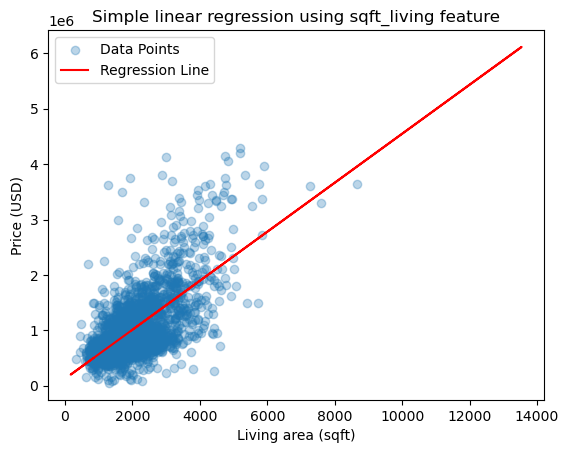

In [30]:
y_pred = linreg.predict(X_train)
# Plot data points
plt.scatter(x = X_train[:2000], y = y_train[:2000], alpha = 0.3, label = 'Data Points')
# Plot regression line
plt.plot(X_train, y_pred, color = 'red', label = 'Regression Line')
plt.legend()
plt.title('Simple linear regression using sqft_living feature')
plt.xlabel('Living area (sqft)')
plt.ylabel('Price (USD)')
plt.show()

In [31]:
#where did this unnamed column come from? let's get rid of it
df_2.drop('Unnamed: 0', axis=1, inplace=True)

In [32]:
# so size isn't super-relevant for king county. let's look at area. we need to drop all area info in 
# order to get our base model. let's also remove object data, since the model can't handle it
X_train = df_2.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode','date'], axis=1)
y_train = df_2['price']

In [33]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     578.2
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:37:21   Log-Likelihood:            -1.2457e+05
No. Observations:                8669   AIC:                         2.492e+05
Df Residuals:                    8649   BIC:                         2.493e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.628e+06 

In [34]:
#well, our model isn't very predictive. probably due to the multicollinearity with the flood data? look at "cond. no."

##let's try removing it


In [35]:
X_train = df_2.drop(['area_flood_score_min','area_flood_score_max', 'avg_area_flood_score','price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode','date', ], axis=1)
y_train = df_2['price']

In [36]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     591.2
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:37:28   Log-Likelihood:            -1.2479e+05
No. Observations:                8669   AIC:                         2.496e+05
Df Residuals:                    8651   BIC:                         2.497e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.535e+06   4.45e+05     

In [37]:
# that made it worse!! let's re-add those (and convert objects to categoricals)
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8669 entries, 0 to 8668
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     8669 non-null   int64  
 1   date                   8669 non-null   object 
 2   bedrooms               8669 non-null   int64  
 3   bathrooms              8669 non-null   float64
 4   sqft_living            8669 non-null   int64  
 5   sqft_lot               8669 non-null   int64  
 6   floors                 8669 non-null   float64
 7   sqft_garage            8669 non-null   int64  
 8   sqft_patio             8669 non-null   int64  
 9   yr_built               8669 non-null   int64  
 10  yr_renovated           8669 non-null   int64  
 11  lat                    8669 non-null   float64
 12  long                   8669 non-null   float64
 13  street address         8669 non-null   object 
 14  city                   8669 non-null   object 
 15  zipc

In [38]:
df_2['street address'] = df_2['street address'].astype('category')
df_2['city'] = df_2['city'].astype('category')
df_2['floodzones_in_zipcode'] = df_2['floodzones_in_zipcode'].astype('category')

In [39]:
df_2.drop(columns=['id', 'date'], axis=1, inplace=True)

In [40]:
X_train = df_2.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode' ], axis=1)
y_train = df_2['price']

In [41]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     609.7
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:37:40   Log-Likelihood:            -1.2458e+05
No. Observations:                8669   AIC:                         2.492e+05
Df Residuals:                    8650   BIC:                         2.493e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.616e+06 

In [42]:
# let's boost this by just looking at one flood score at a time

X_train = df_2.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode', 'area_flood_score_min', 'area_flood_score_max'], axis=1)
y_train = df_2['price']

In [43]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     601.0
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:38:03   Log-Likelihood:            -1.2475e+05
No. Observations:                8669   AIC:                         2.495e+05
Df Residuals:                    8651   BIC:                         2.497e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 7.166e+06 

In [44]:
#worse! 


X_train = df_2.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode', 'area_flood_score_min', 'avg_area_flood_score'], axis=1)
y_train = df_2['price']

In [45]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     591.2
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:38:09   Log-Likelihood:            -1.2479e+05
No. Observations:                8669   AIC:                         2.496e+05
Df Residuals:                    8651   BIC:                         2.497e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   7.5e+06 

In [46]:
# even worse! finally, let's remove the max and area score
#(note, however, that our cond no. scores are dropping)

X_train = df_2.drop(['price','lat', 'long', 'zipcode',  'street address', 'city', 'floodzones_in_zipcode', 'area_flood_score_max', 'avg_area_flood_score'], axis=1)
y_train = df_2['price']


In [47]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     611.0
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:38:13   Log-Likelihood:            -1.2471e+05
No. Observations:                8669   AIC:                         2.495e+05
Df Residuals:                    8651   BIC:                         2.496e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.815e+06 

In [48]:
#better! min score is more predictive!, with the same cond no. 

In [68]:
#let's do some onehot encoding

def one_hot_encode(df, catcols):
    '''Returns df with dummy vars and drops original column'''
    
    # Create DataFrame with above columns
    dfonehot = df[catcols].astype('category')
    
    # Get dummy variables and drop first one to not create dependency
    dfonehot = pd.get_dummies(dfonehot, drop_first = True)
    
    # Recreate DataFrame with one-hot encoded variables
    df = pd.concat([df,dfonehot], axis=1)
    
    # Drop columns where we have done one-hot encoding
    df = df.drop(catcols, axis = 1)
        
    return df

In [69]:
onehot_df = one_hot_encode(df_2, ['grade score', 'has_basement', 'on_waterfront', 'near_greenbelt', 'view score',
       'nuisance'])
onehot_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,...,grade score_12,grade score_13,has_basement_1,on_waterfront_1,near_greenbelt_1,view score_1,view score_2,view score_3,view score_4,nuisance_1
0,3,2.5,1979,13439,1.0,280,280,1963,0,47.281065,...,0,0,1,0,0,0,0,0,0,0
1,4,3.0,2450,8772,2.0,460,460,2021,0,47.192910,...,0,0,0,0,0,0,0,0,0,0
2,3,1.0,1100,3000,1.0,0,0,1911,0,47.673490,...,0,0,0,0,0,0,0,0,0,1
3,4,3.0,3800,10194,1.0,580,0,1975,2006,47.532310,...,0,0,1,0,0,0,0,0,0,0
4,4,3.5,3840,15347,1.0,580,690,1976,0,47.382170,...,0,0,1,0,0,0,1,0,0,0


In [51]:
#let's try linear and mulilinear with this onehot encoded values

In [52]:
X_train = onehot_df.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode', 'area_flood_score_max', 'avg_area_flood_score'], axis=1)
y_train = onehot_df['price']

In [53]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     382.5
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:38:38   Log-Likelihood:            -1.2446e+05
No. Observations:                8669   AIC:                         2.490e+05
Df Residuals:                    8638   BIC:                         2.492e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.798e+06   6.12e+05     11.102      0.000     5.6e+06       8e+06
bedrooms             -2.221e+04   6556.349     -3.388      0.001   -3.51e+04   -9359.010
bathrooms             7.347e+04   9395.902      7.819      0.000    5.51e+04    9.19e+04
sqft_living            218.3676     10.553     20.693      0.000     197.682     239.054
sqft_lot                 0.0521      0.075      0.696      0.486      -0.095       0.199
floors               -1.867e+04   1.12e+04     -1.675      0.094   -4.05e+04    3184.660
sqft_garage            -13.3343     21.481     -0.621      0.535     -55.443      28.774
sqft_patio               4.2857     21.376      0.200      0.841     -37.617      46.189
yr_built             -3314.5540    227.996    -14.538      0.000   -3761.481   -2867.627
yr_renovated            68.9199     11.635      5.924      0.000      46.113      91.727
area_flood_score_min -1.301e+05   9978.266    -13.037      0.000    -1.5e+05   -1.11e+05
condition score       3.987e+04   6933.611      5.750      0.000    2.63e+04    5.35e+04
grade score_3        -1.275e+05   5.13e+05     -0.249      0.804   -1.13e+06    8.77e+05
grade score_4           9.5e+04   4.38e+05      0.217      0.828   -7.63e+05    9.53e+05
grade score_5         1.164e+05   4.21e+05      0.276      0.782   -7.09e+05    9.42e+05
grade score_6         7.717e+04    4.2e+05      0.184      0.854   -7.46e+05       9e+05
grade score_7         1.947e+05    4.2e+05      0.464      0.643   -6.29e+05    1.02e+06
grade score_8         3.713e+05    4.2e+05      0.884      0.377   -4.52e+05    1.19e+06
grade score_9         7.269e+05    4.2e+05      1.729      0.084   -9.74e+04    1.55e+06
grade score_10        1.204e+06   4.21e+05      2.860      0.004    3.79e+05    2.03e+06
grade score_11        1.492e+06   4.23e+05      3.524      0.000    6.62e+05    2.32e+06
grade score_12        1.437e+06   4.32e+05      3.327      0.001     5.9e+05    2.28e+06
grade score_13        1.724e+06   4.63e+05      3.722      0.000    8.16e+05    2.63e+06
has_basement_1       -1.198e+04   1.05e+04     -1.139      0.255   -3.26e+04    8643.395
on_waterfront_1       5.559e+04   4.41e+04      1.262      0.207   -3.08e+04    1.42e+05
near_greenbelt_1      9.555e+04   2.87e+04      3.333      0.001    3.93e+04    1.52e+05
view score_1          1.652e+05   5.44e+04      3.038      0.002    5.86e+04    2.72e+05
view score_2          5.465e+04   1.89e+04      2.888      0.004    1.76e+04    9.17e+04
view score_3          5.614e+04   2.72e+04      2.061      0.039    2736.743     1.1e+05
view score_4          3.426e+05   4.28e+04      8.006      0.000    2.59e+05    4.26e+05
nuisance_1             1.19e+04   1.23e+04      0.970      0.332   -1.21e+04    3.59e+04
=========================================================

In [54]:
# well, we got a tiny R2 improvement, though cond no increased. maybe we need more one-hot encoding?

In [55]:
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([420503.72170212, 408432.62509717, 429445.86753372, 456642.56871875,
       424838.23581093, 405227.44453476, 380331.94050031, 417708.20666884,
       404275.30997427, 433948.50740472])

418135.4427945604

19476.82041517497

In [56]:
# our RMSE scores improved in one respect but the std increased

In [57]:
# let's try onehot encoding more

In [58]:
catcols = ['bedrooms', 'bathrooms', 'floors']

In [59]:
onehot_df_2 = one_hot_encode(onehot_df, catcols)

In [60]:
X_train = onehot_df_2.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode', 'area_flood_score_max', 'avg_area_flood_score'], axis=1)
y_train = onehot_df_2['price']

In [61]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     196.1
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:39:38   Log-Likelihood:            -1.2439e+05
No. Observations:                8669   AIC:                         2.489e+05
Df Residuals:                    8608   BIC:                         2.493e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 7.081e+06   6.35e+05     11.159      0.000    5.84e+06    8.33e+06
sqft_living            211.9854     10.842     19.552      0.000     190.732     233.239
sqft_lot                 0.0957      0.075      1.280      0.201      -0.051       0.242
sqft_garage              6.6015     22.019      0.300      0.764     -36.562      49.765
sqft_patio              -1.2154     21.368     -0.057      0.955     -43.101      40.671
yr_built             -3469.0632    243.388    -14.253      0.000   -3946.161   -2991.965
yr_renovated            68.8020     11.667      5.897      0.000      45.933      91.671
area_flood_score_min -1.271e+05   9973.471    -12.748      0.000   -1.47e+05   -1.08e+05
condition score       4.426e+04   6988.828      6.333      0.000    3.06e+04     5.8e+04
grade score_3         1.044e+05   5.65e+05      0.185      0.854      -1e+06    1.21e+06
grade score_4         2.359e+05   4.89e+05      0.483      0.629   -7.22e+05    1.19e+06
grade score_5         3.527e+05   4.85e+05      0.728      0.467   -5.98e+05     1.3e+06
grade score_6          3.61e+05   4.84e+05      0.746      0.456   -5.87e+05    1.31e+06
grade score_7         5.044e+05   4.84e+05      1.043      0.297   -4.44e+05    1.45e+06
grade score_8         6.907e+05   4.84e+05      1.428      0.153   -2.58e+05    1.64e+06
grade score_9         1.033e+06   4.84e+05      2.133      0.033    8.39e+04    1.98e+06
grade score_10        1.477e+06   4.85e+05      3.046      0.002    5.26e+05    2.43e+06
grade score_11        1.755e+06   4.87e+05      3.605      0.000    8.01e+05    2.71e+06
grade score_12         1.74e+06   4.95e+05      3.515      0.000     7.7e+05    2.71e+06
grade score_13        1.968e+06   5.27e+05      3.732      0.000    9.35e+05       3e+06
has_basement_1       -1.046e+04   1.06e+04     -0.985      0.325   -3.13e+04    1.04e+04
on_waterfront_1       4.354e+04    4.4e+04      0.989      0.323   -4.27e+04     1.3e+05
near_greenbelt_1       9.48e+04   2.85e+04      3.321      0.001    3.88e+04    1.51e+05
view score_1          1.587e+05   5.42e+04      2.928      0.003    5.24e+04    2.65e+05
view score_2          5.257e+04   1.88e+04      2.792      0.005    1.57e+04    8.95e+04
view score_3          5.212e+04   2.71e+04      1.922      0.055   -1043.710    1.05e+05
view score_4            3.6e+05   4.28e+04      8.412      0.000    2.76e+05    4.44e+05
nuisance_1            1.157e+04   1.22e+04      0.946      0.344   -1.24e+04    3.55e+04
bedrooms_1           -5.508e+05   1.91e+05     -2.890      0.004   -9.24e+05   -1.77e+05
bedrooms_2           -6.684e+05   1.87e+05     -3.580      0.000   -1.03e+06   -3.02e+05
bedrooms_3           -6.799e+05   1.87e+05     -3.642      0.000   -1.05e+06   -3.14e+05
bedrooms_4           -6.995e+05   1.87e+05     -3.739    

In [62]:
# we've inched up, but not by much. we still have a lot of multicollinearity. clearly area matters but there's
#maybe too much variety within a zipcode
# let's try getting neighborhood data using geo location

In [70]:
def neighborhood_feat(df):
   
    
    # Define coord column with lat and long
    df['coord'] = list(zip(df['lat'], df['long']))
    
    # Use reverse geocoder
    results = rg.search(list(df['coord']))
    
    # Define neighbourhood list
    neighborhoods = [results[i]['name'] for i in range(0, len(results))]
    
    # Add neighbourhood feature
    df['neighborhood'] = neighborhoods
    
    return df

In [71]:
neighborhood_df = onehot_df_2.copy()

In [72]:
neighborhood_df = neighborhood_feat(neighborhood_df)

Loading formatted geocoded file...


In [73]:
#neighborhood_df = neighborhood_df .drop(['coord', 'lat', 'long', 'zipcode'], axis = 1)
# dropping multicollinearity features
onehot_neighborhood_df = one_hot_encode(neighborhood_df, 'neighborhood')
# Check 


In [74]:
onehot_neighborhood_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8669 entries, 0 to 8668
Columns: 149 entries, sqft_living to Yarrow Point
dtypes: category(3), float64(6), int64(8), object(1), uint8(131)
memory usage: 2.4+ MB


In [75]:
# well, that hardly helped. what is going on here? 

from geopy.distance import geodesic

In [76]:
seattle_lat = 47.6097
seattle_lon = -122.3331


In [77]:
onehot_neighborhood_df['distance from Seattle'] = onehot_neighborhood_df.apply(lambda row: geodesic((seattle_lat, seattle_lon), (row['lat'], row['long'])).miles, axis=1)

In [78]:
onehot_neighborhood_df.columns

Index(['sqft_living', 'sqft_lot', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'lat', 'long', 'street address', 'city',
       ...
       'Tanner', 'Tukwila', 'Union Hill-Novelty Hill', 'Vashon',
       'West Lake Sammamish', 'White Center', 'Woodinville', 'Woodway',
       'Yarrow Point', 'distance from Seattle'],
      dtype='object', length=150)

In [79]:
X_train = onehot_neighborhood_df.drop(['price','lat', 'long', 'zipcode', 'street address', 'coord', 'city', 'floodzones_in_zipcode', 'area_flood_score_max', 'avg_area_flood_score'], axis=1)
y_train = onehot_neighborhood_df['price']

In [80]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [81]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     184.5
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:43:55   Log-Likelihood:            -1.2209e+05
No. Observations:                8669   AIC:                         2.445e+05
Df Residuals:                    8528   BIC:                         2.455e+05
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      2.285e+06   5.17e+05      4.419      0.000    1.27e+06     3.3e+06
sqft_living                 223.2605      8.582     26.015      0.000     206.438     240.084
sqft_lot                      0.3717      0.060      6.153      0.000       0.253       0.490
sqft_garage                  94.5324     17.824      5.304      0.000      59.593     129.472
sqft_patio                   -1.9629     16.697     -0.118      0.906     -34.694      30.768
yr_built                   -994.0148    201.196     -4.941      0.000   -1388.407    -599.623
yr_renovated                 77.4766      9.058      8.553      0.000      59.720      95.233
area_flood_score_min      -3.537e+04   1.19e+04     -2.972      0.003   -5.87e+04    -1.2e+04
condition score            5.732e+04   5516.025     10.391      0.000    4.65e+04    6.81e+04
grade score_3              3.676e+05    4.4e+05      0.836      0.403   -4.94e+05    1.23e+06
grade score_4              2.337e+05   3.83e+05      0.610      0.542   -5.17e+05    9.85e+05
grade score_5               3.46e+05   3.78e+05      0.915      0.360   -3.95e+05    1.09e+06
grade score_6              3.299e+05   3.77e+05      0.875      0.382   -4.09e+05    1.07e+06
grade score_7              3.632e+05   3.77e+05      0.963      0.336   -3.76e+05     1.1e+06
grade score_8              4.349e+05   3.77e+05      1.153      0.249   -3.05e+05    1.17e+06
grade score_9                6.4e+05   3.77e+05      1.695      0.090      -1e+05    1.38e+06
grade score_10             9.518e+05   3.78e+05      2.517      0.012    2.11e+05    1.69e+06
grade score_11             1.237e+06    3.8e+05      3.258      0.001    4.93e+05    1.98e+06
grade score_12             1.189e+06   3.86e+05      3.080      0.002    4.32e+05    1.95e+06
grade score_13             1.493e+06   4.11e+05      3.636      0.000    6.88e+05     2.3e+06
has_basement_1            -6.745e+04   8812.184     -7.654      0.000   -8.47e+04   -5.02e+04
on_waterfront_1            1.511e+05   3.47e+04      4.358      0.000    8.31e+04    2.19e+05
near_greenbelt_1           1.179e+04   2.26e+04      0.521      0.602   -3.25e+04    5.61e+04
view score_1               1.792e+05   4.22e+04      4.242      0.000    9.64e+04    2.62e+05
view score_2               7.552e+04   1.49e+04      5.084      0.000    4.64e+04    1.05e+05
view score_3               1.422e+05   2.13e+04      6.667      0.000       1e+05    1.84e+05
view score_4               4.587e+05   3.38e+04     13.561      0.000    3.92e+05    5.25e+05
nuisance_1                 -3.88e+04   9548.477     -4.063      0.000   -5.75e+04   -2.01e+04
bedrooms_1                 -5.16e+05   1.47e+05     -3.505      0.000   -8.05e+05   -2.27e+05
bedrooms_2                -5.896e+05   1.44e+05     -4.090      0.000   -8.

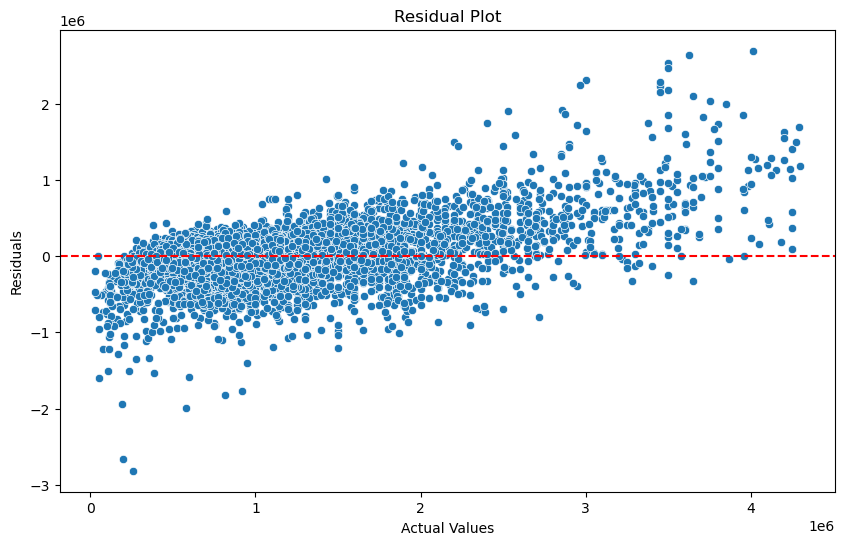

In [82]:
#well, this one variable is sorta powerful! neighborhood made all the difference


# let's visualize this successful R2 model, that added neighborhoods using onehot encoding!:
    
residuals = model.resid

# Create a residual plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

<Figure size 1000x600 with 0 Axes>

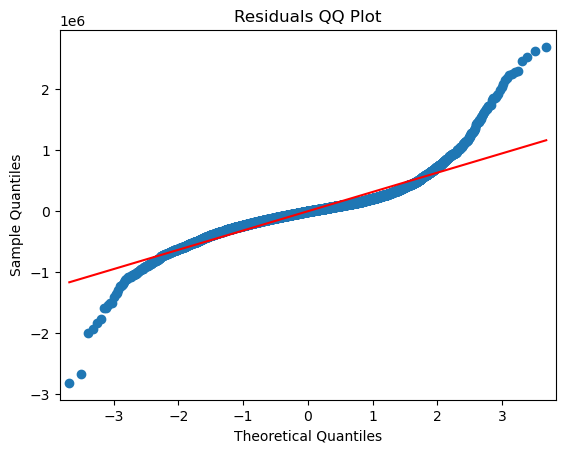

In [83]:
import statsmodels.graphics.gofplots as smg
residuals = model.resid

# Create a residuals QQ plot using statsmodels and matplotlib
plt.figure(figsize=(10, 6))
smg.qqplot(residuals, line='s')
plt.title('Residuals QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

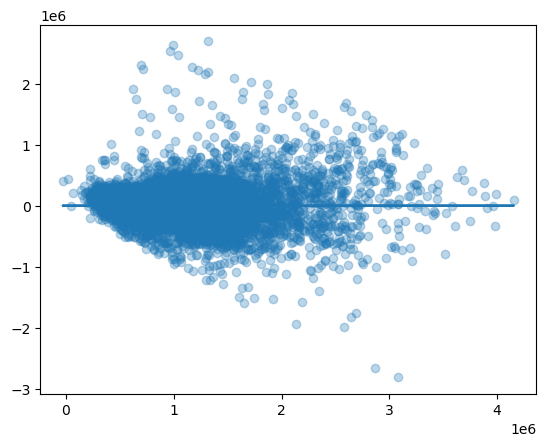

In [84]:
# our residuals still aren't great but let's check another aspect - homo- vs. heteroscedasticity

plt.scatter(model.predict(X_int), model.resid, alpha = 0.3)
plt.plot(model.predict(X_int), [0 for i in range(len(X_train))])
plt.show()


In [87]:
# should we go back and log transform? probably in an ideal world, but this isn't too bad
# but let's experiment really quickly:

price = neighborhood_df['price']
neighborhood_df['log_price'] = price


# Print the transformed data
print(log_price)

NameError: name 'log_price' is not defined

In [88]:
neighborhood_df

,sqft_living,sqft_lot,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,street address,city,...,bathrooms_10.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,floors_4.0,coord,neighborhood,log_price
0,1979,13439,280,280,1963,0,47.281065,-122.298820,35770 27th Avenue South,Federal Way,...,0,0,0,0,0,0,0,"(47.28106500000001, -122.29882)",Lakeland South,600000.0
1,2450,8772,460,460,2021,0,47.192910,-121.980870,243 Hogan Dr,Enumclaw,...,0,0,1,0,0,0,0,"(47.19291, -121.98087)",Enumclaw,698507.0
2,1100,3000,0,0,1911,0,47.673490,-122.323730,6045 5th Avenue Northeast,Seattle,...,0,0,0,0,0,0,0,"(47.67349, -122.32373)",Seattle,686500.0
3,3800,10194,580,0,1975,2006,47.532310,-122.226250,7815 85th Place Southeast,Mercer Island,...,0,0,0,0,0,0,0,"(47.53231, -122.22625)",Mercer Island,2720000.0
4,3840,15347,580,690,1976,0,47.382170,-122.150270,14327 Southeast 243rd Street,Kent,...,0,0,0,0,0,0,0,"(47.38217, -122.15027)",East Hill-Meridian,900000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8664,2050,6250,330,60,1940,0,47.568830,-122.402505,3916 55th Avenue Southwest,Seattle,...,0,0,0,0,0,0,0,"(47.56883, -122.402505)",White Center,1450000.0
8665,2150,1342,380,530,2021,0,47.593319,-122.294430,1101 Yakima Avenue South,Seattle,...,0,0,0,0,1,0,0,"(47.593319, -122.29443)",Seattle,1460000.0
8666,2560,4116,510,260,2021,0,47.359860,-122.026100,27016 235th Place Southeast,Maple Valley,...,0,0,1,0,0,0,0,"(47.35986, -122.0261)",Maple Valley,892589.0
8667,2560,4547,410,170,2022,0,47.359710,-122.076180,27018 199th Avenue Southeast,Covington,...,0,0,1,0,0,0,0,"(47.35971, -122.07618)",Lake Morton-Berrydale,748950.0


In [89]:
#let's add this to the onehot model!

onehot_neighborhood_df['log_price'] = price

# Print the transformed data
print(log_price)

NameError: name 'log_price' is not defined

In [90]:
X_train = onehot_neighborhood_df.drop(['log_price','price','lat', 'long', 'zipcode', 'street address', 'coord', 'city', 'floodzones_in_zipcode', 'area_flood_score_max', 'avg_area_flood_score'], axis=1)
y_train = onehot_neighborhood_df['log_price']

In [91]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     184.5
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:46:44   Log-Likelihood:            -1.2209e+05
No. Observations:                8669   AIC:                         2.445e+05
Df Residuals:                    8528   BIC:                         2.455e+05
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      2.285e+06   5.17e+05      4.419      0.000    1.27e+06     3.3e+06
sqft_living                 223.2605      8.582     26.015      0.000     206.438     240.084
sqft_lot                      0.3717      0.060      6.153      0.000       0.253       0.490
sqft_garage                  94.5324     17.824      5.304      0.000      59.593     129.472
sqft_patio                   -1.9629     16.697     -0.118      0.906     -34.694      30.768
yr_built                   -994.0148    201.196     -4.941      0.000   -1388.407    -599.623
yr_renovated                 77.4766      9.058      8.553      0.000      59.720      95.233
area_flood_score_min      -3.537e+04   1.19e+04     -2.972      0.003   -5.87e+04    -1.2e+04
condition score            5.732e+04   5516.025     10.391      0.000    4.65e+04    6.81e+04
grade score_3              3.676e+05    4.4e+05      0.836      0.403   -4.94e+05    1.23e+06
grade score_4              2.337e+05   3.83e+05      0.610      0.542   -5.17e+05    9.85e+05
grade score_5               3.46e+05   3.78e+05      0.915      0.360   -3.95e+05    1.09e+06
grade score_6              3.299e+05   3.77e+05      0.875      0.382   -4.09e+05    1.07e+06
grade score_7              3.632e+05   3.77e+05      0.963      0.336   -3.76e+05     1.1e+06
grade score_8              4.349e+05   3.77e+05      1.153      0.249   -3.05e+05    1.17e+06
grade score_9                6.4e+05   3.77e+05      1.695      0.090      -1e+05    1.38e+06
grade score_10             9.518e+05   3.78e+05      2.517      0.012    2.11e+05    1.69e+06
grade score_11             1.237e+06    3.8e+05      3.258      0.001    4.93e+05    1.98e+06
grade score_12             1.189e+06   3.86e+05      3.080      0.002    4.32e+05    1.95e+06
grade score_13             1.493e+06   4.11e+05      3.636      0.000    6.88e+05     2.3e+06
has_basement_1            -6.745e+04   8812.184     -7.654      0.000   -8.47e+04   -5.02e+04
on_waterfront_1            1.511e+05   3.47e+04      4.358      0.000    8.31e+04    2.19e+05
near_greenbelt_1           1.179e+04   2.26e+04      0.521      0.602   -3.25e+04    5.61e+04
view score_1               1.792e+05   4.22e+04      4.242      0.000    9.64e+04    2.62e+05
view score_2               7.552e+04   1.49e+04      5.084      0.000    4.64e+04    1.05e+05
view score_3               1.422e+05   2.13e+04      6.667      0.000       1e+05    1.84e+05
view score_4               4.587e+05   3.38e+04     13.561      0.000    3.92e+05    5.25e+05
nuisance_1                 -3.88e+04   9548.477     -4.063      0.000   -5.75e+04   -2.01e+04
bedrooms_1                 -5.16e+05   1.47e+05     -3.505      0.000   -8.05e+05   -2.27e+05
bedrooms_2                -5.896e+05   1.44e+05     -4.090      0.000   -8.

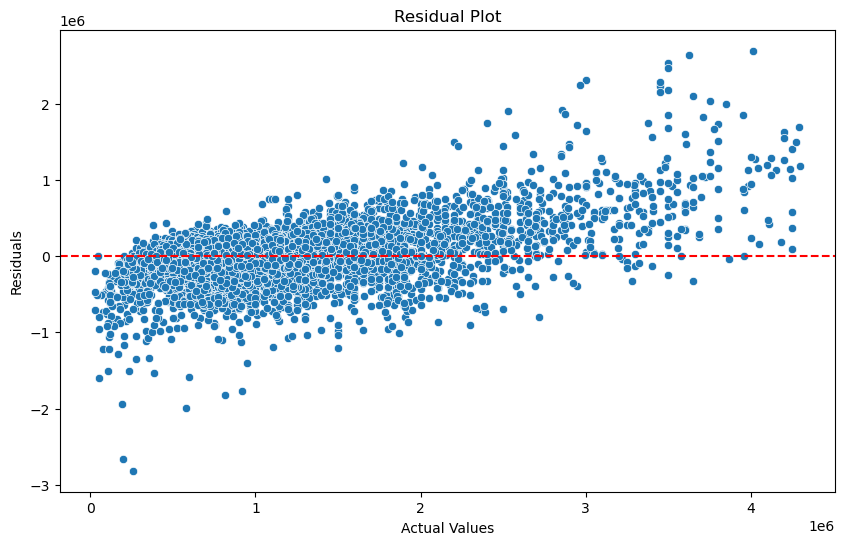

In [92]:
# well, our R2 is sthe same. cond isn't much better. let's look at residuals!
# let's visualize this successful R2 model, that added neighborhoods using onehot encoding!:
    
residuals = model.resid

# Create a residual plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

<Figure size 1000x600 with 0 Axes>

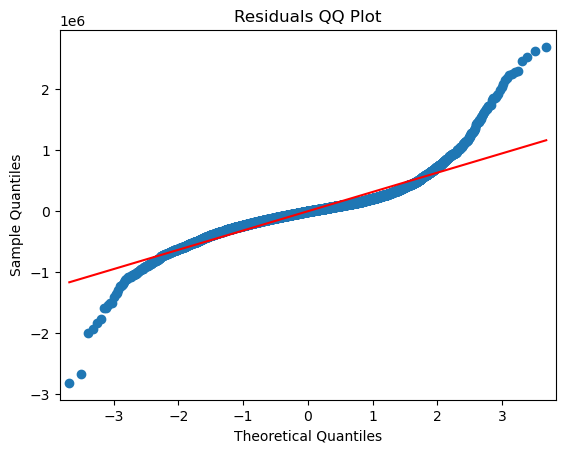

In [93]:
# log transform didn't do much. one last residual plot:

plt.figure(figsize=(10, 6))
smg.qqplot(residuals, line='s')
plt.title('Residuals QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In [94]:
# pretty much identical. let's get rid of log price

neighborhood_df.drop('log_price', axis= 1, inplace=True)
onehot_neighborhood_df.drop('log_price', axis= 1, inplace=True)

In [95]:
# these are the top median neighborhoods by price 


test = neighborhood_df.groupby(neighborhood_df['neighborhood'])['price'].median().sort_values(ascending = False)

# Reset index after groupy
test = test.reset_index()


test.iloc[:50]

,neighborhood,price
0,Clyde Hill,3220000.0
1,Medina,2820000.0
2,Kirkland,1900000.0
3,Yarrow Point,1850000.0
4,Ames Lake,1805000.0
5,Bellevue,1800000.0
6,Mercer Island,1700000.0
7,West Lake Sammamish,1680000.0
8,Maltby,1650000.0
9,Newport,1600000.0


In [96]:
# these are the most flood-safe neighborhoods


test_2 = neighborhood_df.groupby(neighborhood_df['neighborhood'])['area_flood_score_min'].median().sort_values(ascending = True)

# Reset index after groupy
test_2 = test_2.reset_index()

test_2.iloc[:50]
# Reset index after groupy

,neighborhood,area_flood_score_min
0,Yarrow Point,1.000000
1,Kingsgate,1.000000
2,Mercer Island,1.000000
3,Milton,1.000000
4,Inglewood-Finn Hill,1.000000
5,Federal Way,1.000000
6,Seattle,1.000000
7,Medina,1.000000
8,Black Diamond,1.000000
9,Fife Heights,1.666667


In [97]:
#using least conservative flood score
# Group the 'Neighborhood' column by 'Price' (descending) and 'Flood_Score' (ascending)
grouped = neighborhood_df.groupby('neighborhood').apply(lambda x: x.sort_values(by=['price', 'area_flood_score_min'], ascending=[False, True]))

# Filter the neighborhoods with high price and low flood score
filtered = grouped[(grouped['price'] > grouped['price'].mean()) & (grouped['area_flood_score_min'] < 2)]

# Retrieve the filtered neighborhoods
neighborhoods = filtered['neighborhood'].unique()

# Display the filtered neighborhoods
print(neighborhoods)

['Ames Lake' 'Black Diamond' 'Bryn Mawr-Skyway' 'Buckley' 'Burien'
 'City of Sammamish' 'Clyde Hill' 'East Renton Highlands' 'Enumclaw'
 'Esperance' 'Fairwood' 'Federal Way' 'Fife Heights' 'Inglewood-Finn Hill'
 'Kingsgate' 'Kirkland' 'Lake Forest Park' 'Lake Morton-Berrydale'
 'Maple Heights-Lake Desire' 'Maple Valley' 'Medina' 'Mercer Island'
 'Newcastle' 'Ravensdale' 'Riverton' 'Sammamish' 'Seattle' 'Shoreline'
 'Tacoma' 'West Lake Sammamish' 'White Center' 'Woodway' 'Yarrow Point']


In [98]:
# using the most conservative flood score

grouped_2 = neighborhood_df.groupby('neighborhood').apply(lambda x: x.sort_values(by=['price', 'area_flood_score_max'], ascending=[False, True]))

# Filter the neighborhoods with high price and low flood score
filtered_2 = grouped_2[(grouped['price'] > grouped_2['price'].mean()) & (grouped_2['area_flood_score_min'] < 2)]

# Retrieve the filtered neighborhoods
neighborhoods_2 = filtered_2['neighborhood'].unique()

# Display the filtered neighborhoods
print(neighborhoods_2)

['Ames Lake' 'Black Diamond' 'Bryn Mawr-Skyway' 'Buckley' 'Burien'
 'City of Sammamish' 'Clyde Hill' 'East Renton Highlands' 'Enumclaw'
 'Esperance' 'Fairwood' 'Federal Way' 'Fife Heights' 'Inglewood-Finn Hill'
 'Kingsgate' 'Kirkland' 'Lake Forest Park' 'Lake Morton-Berrydale'
 'Maple Heights-Lake Desire' 'Maple Valley' 'Medina' 'Mercer Island'
 'Newcastle' 'Ravensdale' 'Riverton' 'Sammamish' 'Seattle' 'Shoreline'
 'Tacoma' 'West Lake Sammamish' 'White Center' 'Woodway' 'Yarrow Point']


In [99]:
# using the average flood score

grouped_3 = neighborhood_df.groupby('neighborhood').apply(lambda x: x.sort_values(by=['price', 'avg_area_flood_score'], ascending=[False, True]))

# Filter the neighborhoods with high price and low flood score
filtered_3 = grouped_3[(grouped['price'] > grouped_3['price'].mean()) & (grouped_3['area_flood_score_min'] < 2)]

# Retrieve the filtered neighborhoods
neighborhoods_3 = filtered_3['neighborhood'].unique()

# Display the filtered neighborhoods
print(neighborhoods_3)

['Ames Lake' 'Black Diamond' 'Bryn Mawr-Skyway' 'Buckley' 'Burien'
 'City of Sammamish' 'Clyde Hill' 'East Renton Highlands' 'Enumclaw'
 'Esperance' 'Fairwood' 'Federal Way' 'Fife Heights' 'Inglewood-Finn Hill'
 'Kingsgate' 'Kirkland' 'Lake Forest Park' 'Lake Morton-Berrydale'
 'Maple Heights-Lake Desire' 'Maple Valley' 'Medina' 'Mercer Island'
 'Newcastle' 'Ravensdale' 'Riverton' 'Sammamish' 'Seattle' 'Shoreline'
 'Tacoma' 'West Lake Sammamish' 'White Center' 'Woodway' 'Yarrow Point']


In [102]:
# they're all the same!
# need to test, np. where eg column equals kirland, return flood score and then get the mean, min, max etc. 
# also check against MEDIAN values, different flood scores

neighborhood_df.loc([neighborhood_df['neighborhood'] == 'Kirkland'])



TypeError: unhashable type: 'list'

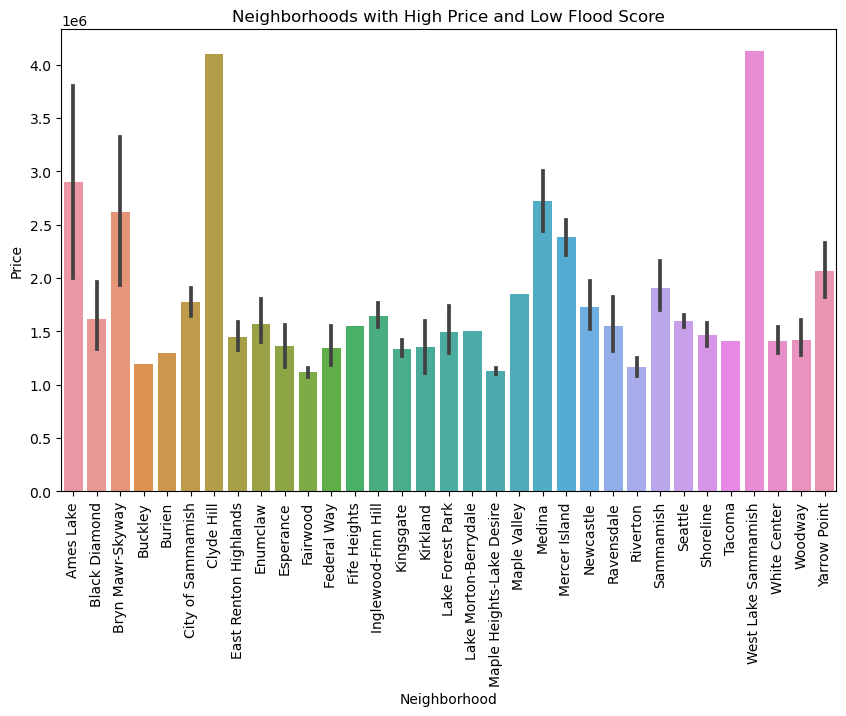

In [103]:
# let's get some visualizations for all our hard work!

plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_3, x='neighborhood', y='price')
plt.title('Neighborhoods with High Price and Low Flood Score')
plt.xlabel('Neighborhood')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

In [104]:
# neighborhoods with high prices and high flood scores:

grouped_4 = neighborhood_df.groupby('neighborhood').apply(lambda x: x.sort_values(by=['price', 'avg_area_flood_score'], ascending=[False, False]))

# Filter the neighborhoods with high price and low flood score
filtered_4 = grouped_4[(grouped['price'] > grouped_3['price'].mean()) & (grouped_3['area_flood_score_min'] > 2)]

# Retrieve the filtered neighborhoods
neighborhoods_4 = filtered_4['neighborhood'].unique()

# Display the filtered neighborhoods
print(neighborhoods_4)

['Algona' 'Ames Lake' 'Brier' 'Burien' 'Carnation' 'Cottage Lake'
 'Covington' 'Des Moines' 'Duvall' 'East Hill-Meridian'
 'East Renton Highlands' 'Eastgate' 'Fairwood' 'Fall City' 'Federal Way'
 'Gold Bar' 'Hobart' 'Inglewood-Finn Hill' 'Issaquah' 'Kenmore' 'Kent'
 'Kingsgate' 'Lake Forest Park' 'Lake Marcel-Stillwater'
 'Lake Morton-Berrydale' 'Lakeland North' 'Lea Hill'
 'Maple Heights-Lake Desire' 'Maple Valley' 'Mirrormont' 'Newcastle'
 'Newport' 'Normandy Park' 'North Bend' 'Ravensdale' 'Redmond' 'Renton'
 'Riverbend' 'Riverton' 'Sammamish' 'SeaTac' 'Seattle' 'Snoqualmie'
 'Tanner' 'Union Hill-Novelty Hill' 'West Lake Sammamish' 'White Center']


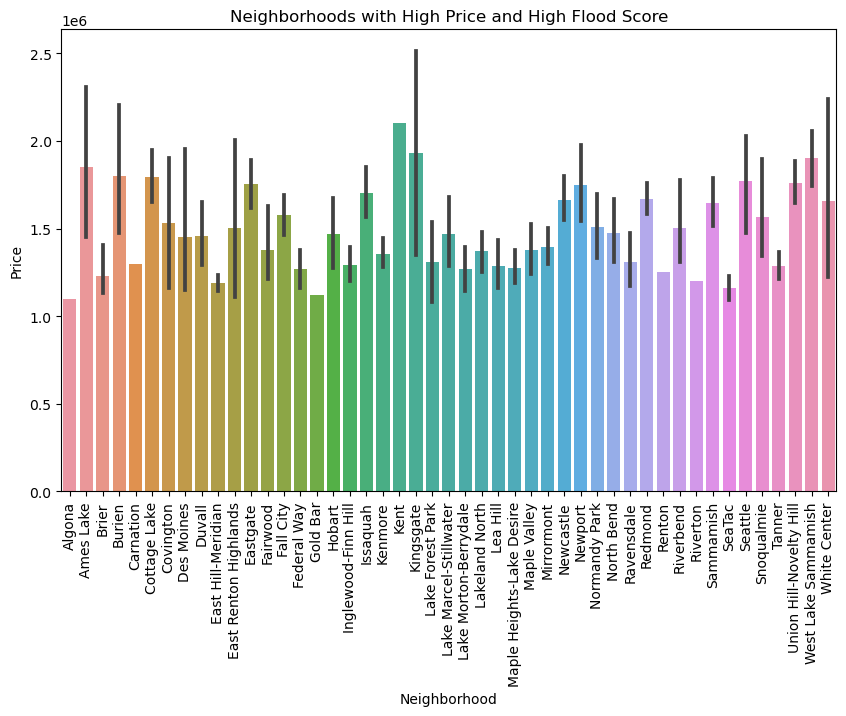

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the grouped_4 dataframe and filter the neighborhoods
grouped_4 = neighborhood_df.groupby('neighborhood').apply(lambda x: x.sort_values(by=['price', 'avg_area_flood_score'], ascending=[False, False]))
filtered_4 = grouped_4[(grouped_4['price'] > grouped_4['price'].mean()) & (grouped_4['area_flood_score_min'] > 2)]
neighborhoods_4 = filtered_4['neighborhood'].unique()

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_4, x='neighborhood', y='price')
plt.title('Neighborhoods with High Price and High Flood Score')
plt.xlabel('Neighborhood')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()


In [106]:
neighborhoods_4

array(['Algona', 'Ames Lake', 'Brier', 'Burien', 'Carnation',
       'Cottage Lake', 'Covington', 'Des Moines', 'Duvall',
       'East Hill-Meridian', 'East Renton Highlands', 'Eastgate',
       'Fairwood', 'Fall City', 'Federal Way', 'Gold Bar', 'Hobart',
       'Inglewood-Finn Hill', 'Issaquah', 'Kenmore', 'Kent', 'Kingsgate',
       'Lake Forest Park', 'Lake Marcel-Stillwater',
       'Lake Morton-Berrydale', 'Lakeland North', 'Lea Hill',
       'Maple Heights-Lake Desire', 'Maple Valley', 'Mirrormont',
       'Newcastle', 'Newport', 'Normandy Park', 'North Bend',
       'Ravensdale', 'Redmond', 'Renton', 'Riverbend', 'Riverton',
       'Sammamish', 'SeaTac', 'Seattle', 'Snoqualmie', 'Tanner',
       'Union Hill-Novelty Hill', 'West Lake Sammamish', 'White Center'],
      dtype=object)

In [107]:
neighborhood_df.columns

Index(['sqft_living', 'sqft_lot', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'lat', 'long', 'street address', 'city', 'zipcode',
       'floodzones_in_zipcode', 'area_flood_score_max', 'area_flood_score_min',
       'avg_area_flood_score', 'price', 'condition score', 'grade score_3',
       'grade score_4', 'grade score_5', 'grade score_6', 'grade score_7',
       'grade score_8', 'grade score_9', 'grade score_10', 'grade score_11',
       'grade score_12', 'grade score_13', 'has_basement_1', 'on_waterfront_1',
       'near_greenbelt_1', 'view score_1', 'view score_2', 'view score_3',
       'view score_4', 'nuisance_1', 'bedrooms_1', 'bedrooms_2', 'bedrooms_3',
       'bedrooms_4', 'bedrooms_5', 'bedrooms_6', 'bedrooms_7', 'bedrooms_8',
       'bedrooms_9', 'bedrooms_10', 'bathrooms_0.5', 'bathrooms_1.0',
       'bathrooms_1.5', 'bathrooms_2.0', 'bathrooms_2.5', 'bathrooms_3.0',
       'bathrooms_3.5', 'bathrooms_4.0', 'bathrooms_4.5', 'bathrooms_5.0',
       'bat

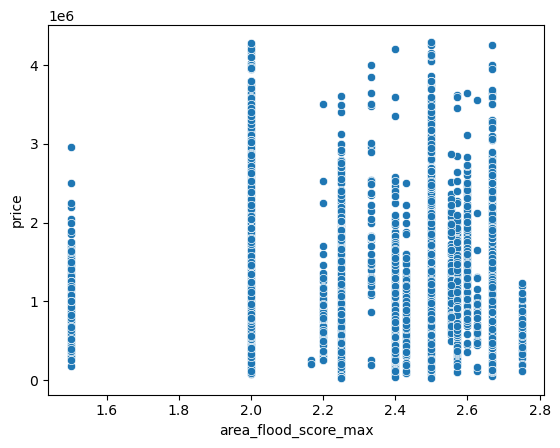

In [108]:
sns.scatterplot(data=neighborhood_df, x='area_flood_score_max', y='price')
plt.show()

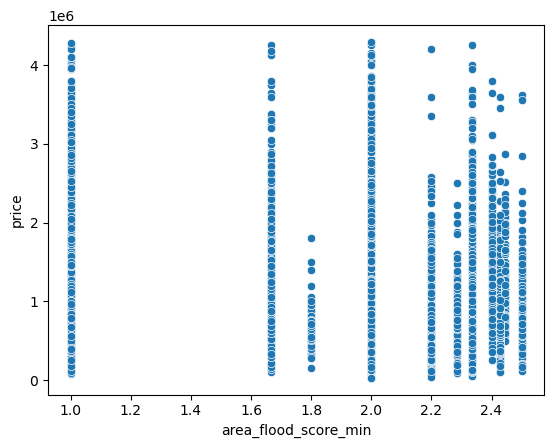

In [109]:
sns.scatterplot(data=neighborhood_df, x='area_flood_score_min', y='price')
plt.show()

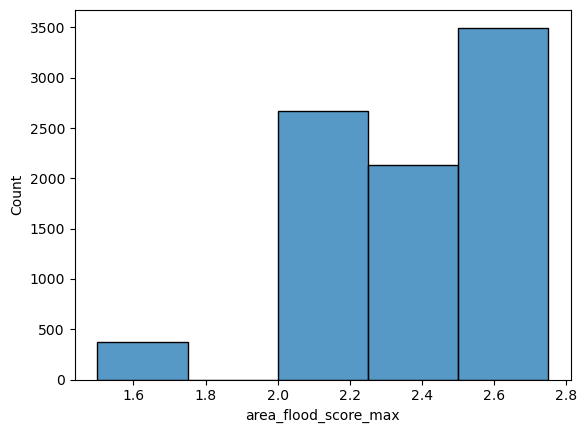

In [110]:
sns.histplot(data=neighborhood_df, x='area_flood_score_max', bins=5)
plt.show()

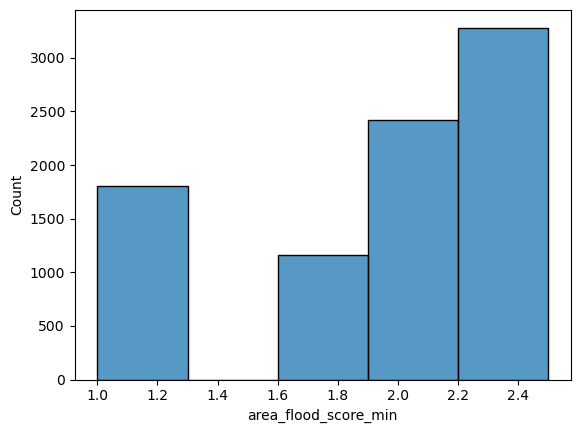

In [111]:
sns.histplot(data=neighborhood_df, x='area_flood_score_min', bins=5)
plt.show()

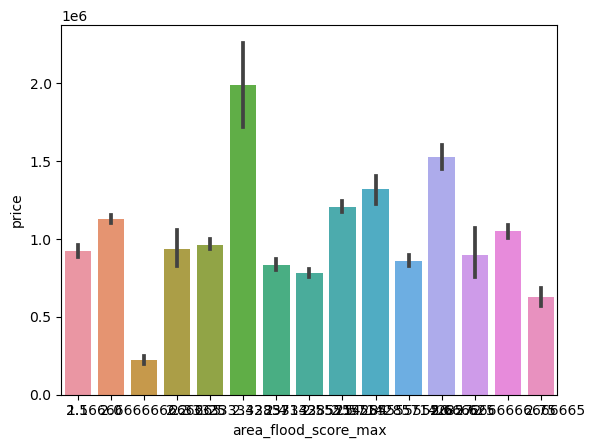

In [112]:
sns.barplot(data=neighborhood_df, x='area_flood_score_max', y='price')
plt.show()

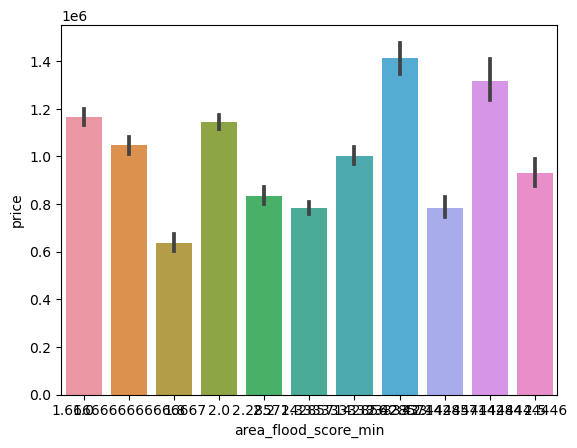

In [113]:
sns.barplot(data=neighborhood_df, x='area_flood_score_min', y='price')
plt.show()

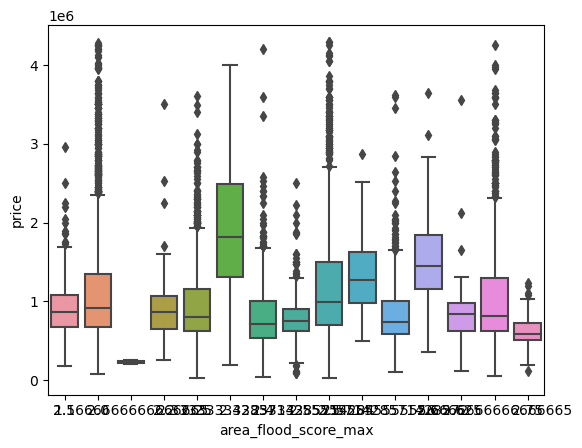

In [114]:
sns.boxplot(data=neighborhood_df, x='area_flood_score_max', y='price')
plt.show()

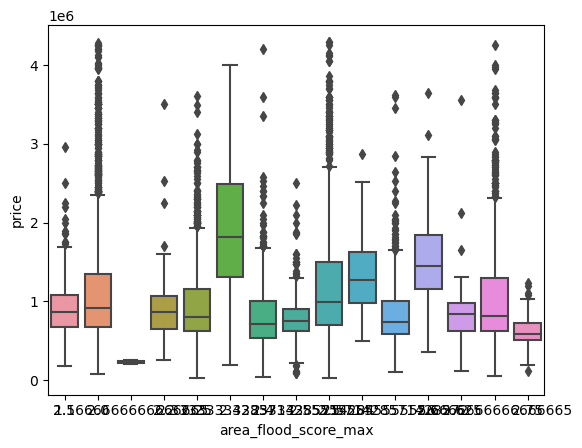

In [115]:
sns.boxplot(data=neighborhood_df, x='area_flood_score_max', y='price')
plt.show()

In [104]:
train_df = pd.read_csv('/Users/jdapeman/Documents/Kings_C_PROJECT/cleaned_train_3.csv')

In [105]:
test_df = neighborhood_df

In [106]:
test_df

,sqft_living,sqft_lot,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,street address,city,...,bathrooms_7.5,bathrooms_9.5,bathrooms_10.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,floors_4.0,coord
0,1979,13439,280,280,1963,0,47.281065,-122.298820,35770 27th Avenue South,Federal Way,...,0,0,0,0,0,0,0,0,0,"(47.28106500000001, -122.29882)"
1,2450,8772,460,460,2021,0,47.192910,-121.980870,243 Hogan Dr,Enumclaw,...,0,0,0,0,1,0,0,0,0,"(47.19291, -121.98087)"
2,1100,3000,0,0,1911,0,47.673490,-122.323730,6045 5th Avenue Northeast,Seattle,...,0,0,0,0,0,0,0,0,0,"(47.67349, -122.32373)"
3,3800,10194,580,0,1975,2006,47.532310,-122.226250,7815 85th Place Southeast,Mercer Island,...,0,0,0,0,0,0,0,0,0,"(47.53231, -122.22625)"
4,3840,15347,580,690,1976,0,47.382170,-122.150270,14327 Southeast 243rd Street,Kent,...,0,0,0,0,0,0,0,0,0,"(47.38217, -122.15027)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8664,2050,6250,330,60,1940,0,47.568830,-122.402505,3916 55th Avenue Southwest,Seattle,...,0,0,0,0,0,0,0,0,0,"(47.56883, -122.402505)"
8665,2150,1342,380,530,2021,0,47.593319,-122.294430,1101 Yakima Avenue South,Seattle,...,0,0,0,0,0,0,1,0,0,"(47.593319, -122.29443)"
8666,2560,4116,510,260,2021,0,47.359860,-122.026100,27016 235th Place Southeast,Maple Valley,...,0,0,0,0,1,0,0,0,0,"(47.35986, -122.0261)"
8667,2560,4547,410,170,2022,0,47.359710,-122.076180,27018 199th Avenue Southeast,Covington,...,0,0,0,0,1,0,0,0,0,"(47.35971, -122.07618)"


In [107]:
train_df

,Unnamed: 0,sqft_living,sqft_lot,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,street address,...,bathrooms_4.0,bathrooms_4.5,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,floors_4.0,coord,neighborhood
0,0,1420,10364,380,0,1961,0,47.343920,-122.285400,3705 South 287th Street,...,0,0,0,0,0,0,0,0,"(47.34392, -122.2854)",Lakeland North
1,1,4100,10400,0,460,1958,0,47.586060,-122.114880,2648 169th Avenue Southeast,...,0,0,0,0,0,0,0,0,"(47.58606, -122.11488)",West Lake Sammamish
2,2,2170,6853,580,200,2004,0,47.710940,-122.032950,12527 230th Place Northeast,...,0,0,0,0,0,0,0,0,"(47.71094, -122.03295)",Union Hill-Novelty Hill
3,3,2310,3830,470,50,2006,0,47.553735,-121.989655,3447 Northeast Monterey Lane,...,0,0,0,1,0,0,0,0,"(47.553735, -121.989655)",Issaquah
4,4,1240,5200,0,80,1969,0,47.370090,-122.078940,19615 Southeast 259th Street,...,0,0,0,0,0,0,0,0,"(47.37009000000001, -122.07894)",Maple Valley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18800,18800,2020,43560,530,60,1978,0,47.384120,-122.084910,24215 193rd Avenue Southeast,...,0,0,0,1,0,0,0,0,"(47.38412, -122.08491)",Maple Valley
18801,18801,1955,4465,534,150,2013,0,47.340880,-122.179965,29104 120th Way Southeast,...,0,0,0,1,0,0,0,0,"(47.34088, -122.179965)",Lea Hill
18802,18802,1350,9509,220,0,1955,0,47.772990,-122.338755,1639 North 199th Street,...,0,0,0,0,0,0,0,0,"(47.77299, -122.338755)",Shoreline
18803,18803,2280,8136,0,170,1967,0,47.341670,-122.287840,3434 South 290th Street,...,0,0,0,0,0,0,0,0,"(47.34167, -122.28784)",Lakeland North


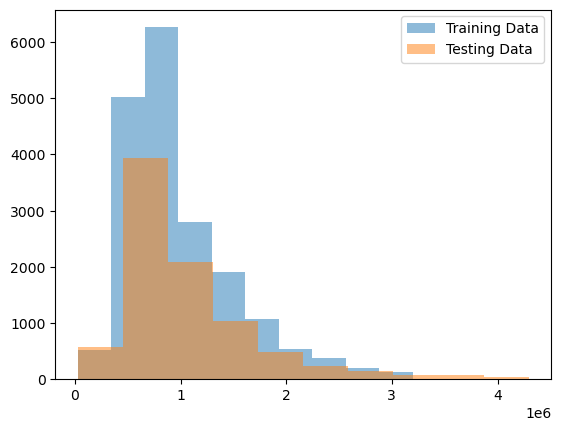

In [108]:
# Plot histograms to compare a specific column
plt.hist(train_df['price'], alpha=0.5, label='Training Data')
plt.hist(test_df['price'], alpha=0.5, label='Testing Data')
plt.legend()
plt.show()

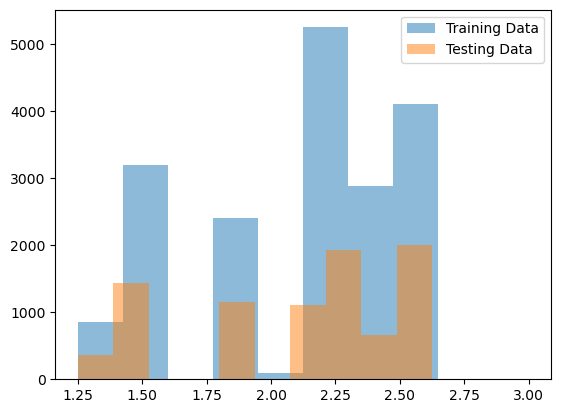

In [109]:
plt.hist(train_df['avg_area_flood_score'], alpha=0.5, label='Training Data')
plt.hist(test_df['avg_area_flood_score'], alpha=0.5, label='Testing Data')
plt.legend()
plt.show()

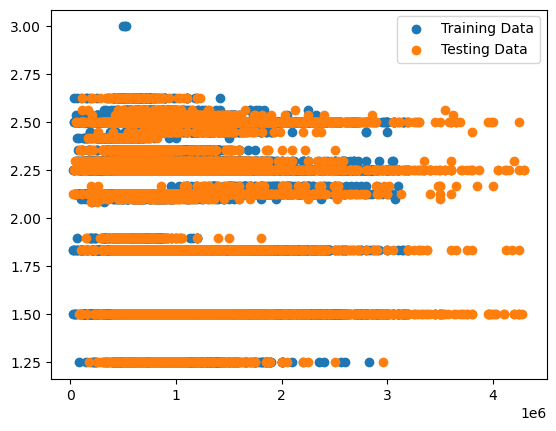

In [110]:
plt.scatter(train_df['price'], train_df['avg_area_flood_score'], label='Training Data')
plt.scatter(test_df['price'], test_df['avg_area_flood_score'], label='Testing Data')
plt.legend()
plt.show()

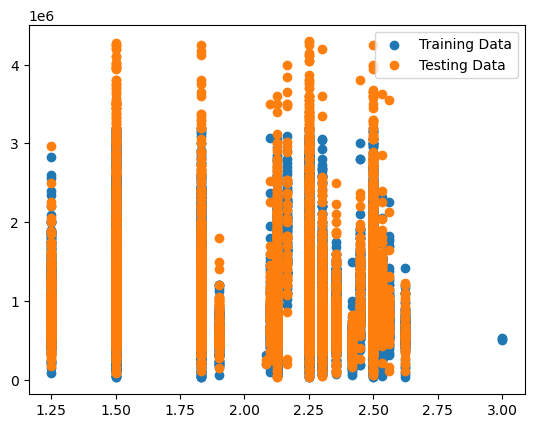

In [111]:
plt.scatter(train_df['avg_area_flood_score'], train_df['price'], label='Training Data')
plt.scatter(test_df['avg_area_flood_score'], test_df['price'], label='Testing Data')
plt.legend()
plt.show()

In [112]:
t_statistic, p_value = stats.ttest_ind(train_df['avg_area_flood_score'], test_df['avg_area_flood_score'])


# Print the test results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -1.14523631796797
P-Value: 0.25212125431978927


In [113]:
t_statistic, p_value = stats.ttest_ind(train_df['price'], test_df['price'])


# Print the test results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -9.655820882886957
P-Value: 5.034135149903695e-22


In [114]:
test_df.describe()

,sqft_living,sqft_lot,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,zipcode,area_flood_score_max,...,bathrooms_7.0,bathrooms_7.5,bathrooms_9.5,bathrooms_10.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,floors_4.0
count,8669.000000,8.669000e+03,8669.000000,8669.000000,8669.000000,8669.000000,8669.000000,8669.000000,8669.000000,8669.000000,...,8669.000000,8669.000000,8669.000000,8669.000000,8669.000000,8669.000000,8669.000000,8669.000000,8669.000000,8669.000000
mean,2107.565002,1.710479e+04,331.007383,211.988926,1973.400623,89.898374,47.543476,-122.213347,98078.007267,2.294378,...,0.000115,0.000577,0.000115,0.000115,0.083631,0.395201,0.006806,0.030684,0.000231,0.000807
std,930.528664,6.217496e+04,282.128767,238.148923,31.592372,414.239953,0.145910,0.145833,54.278906,0.297910,...,0.010740,0.024010,0.010740,0.010740,0.276850,0.488922,0.082221,0.172470,0.015188,0.028406
min,170.000000,4.750000e+02,0.000000,0.000000,1900.000000,0.000000,47.176375,-122.526650,98001.000000,1.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1440.000000,5.000000e+03,0.000000,40.000000,1952.000000,0.000000,47.428255,-122.328000,98033.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1940.000000,7.560000e+03,400.000000,140.000000,1976.000000,0.000000,47.558100,-122.234710,98065.000000,2.400000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2610.000000,1.065000e+04,510.000000,310.000000,2000.000000,0.000000,47.672525,-122.123798,98117.000000,2.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,13540.000000,3.067495e+06,2840.000000,2880.000000,2022.000000,2022.000000,47.777445,-121.163960,98288.000000,2.750000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [115]:
train_df.describe()

,Unnamed: 0,sqft_living,sqft_lot,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,zipcode,...,bathrooms_3.0,bathrooms_3.5,bathrooms_4.0,bathrooms_4.5,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,floors_4.0
count,18805.000000,18805.000000,18805.000000,18805.000000,18805.000000,18805.000000,18805.000000,18805.000000,18805.000000,18805.000000,...,18805.000000,18805.000000,18805.000000,18805.000000,18805.000000,18805.000000,18805.000000,18805.000000,18805.000000,18805.000000
mean,9402.000000,1996.672853,10721.850359,316.523691,184.786546,1973.035150,88.418825,47.541653,-122.219368,98078.696357,...,0.142888,0.064983,0.017176,0.007604,0.083967,0.388833,0.005477,0.028875,0.000319,0.000957
std,5428.680242,775.722392,15600.472232,258.247879,187.671494,31.750352,410.983239,0.146715,0.141465,54.385733,...,0.349967,0.246502,0.129931,0.086873,0.277346,0.487498,0.073808,0.167460,0.017860,0.030925
min,0.000000,100.000000,402.000000,0.000000,0.000000,1900.000000,0.000000,47.155265,-122.525810,98001.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4701.000000,1410.000000,4916.000000,0.000000,30.000000,1951.000000,0.000000,47.426225,-122.332270,98033.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9402.000000,1880.000000,7340.000000,390.000000,130.000000,1975.000000,0.000000,47.553270,-122.248560,98065.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14103.000000,2490.000000,10000.000000,500.000000,282.000000,2000.000000,0.000000,47.672810,-122.137585,98118.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,18804.000000,4750.000000,188769.000000,1112.000000,873.000000,2022.000000,2022.000000,47.789830,-121.315510,98288.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


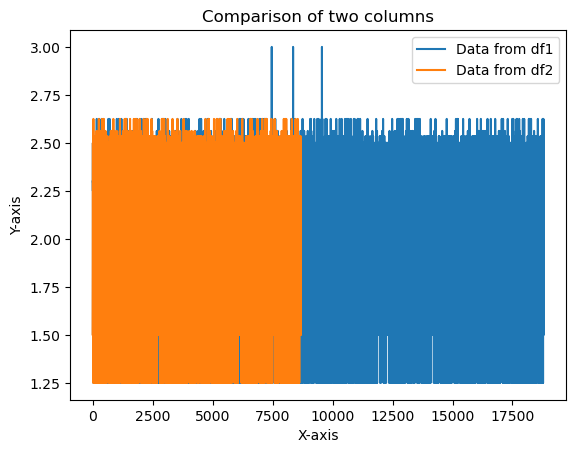

In [116]:
plt.plot(train_df['avg_area_flood_score'], label='Data from df1')

# Plotting data from df2
plt.plot(test_df['avg_area_flood_score'], label='Data from df2')

# Adding labels and title to the graph
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Comparison of two columns')

# Adding a legend to differentiate the data
plt.legend()

# Displaying the graph
plt.show()

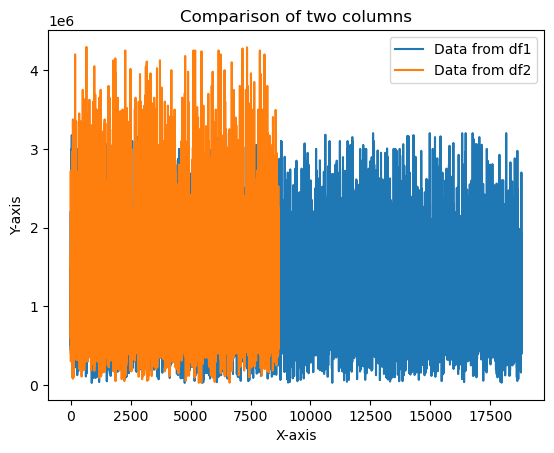

In [117]:
plt.plot(train_df['price'], label='Data from df1')

# Plotting data from df2
plt.plot(test_df['price'], label='Data from df2')

# Adding labels and title to the graph
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Comparison of two columns')

# Adding a legend to differentiate the data
plt.legend()

# Displaying the graph
plt.show()

<Axes: >

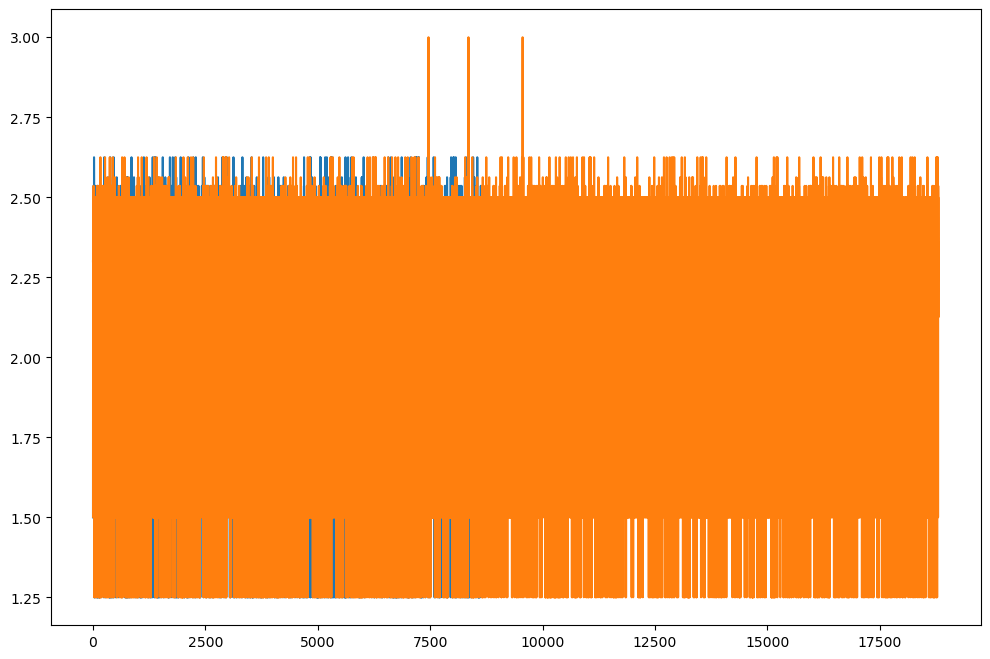

In [118]:
ax = test_df['avg_area_flood_score'].plot(figsize=(12,8))
train_df['avg_area_flood_score'].plot(ax=ax)

<Axes: >

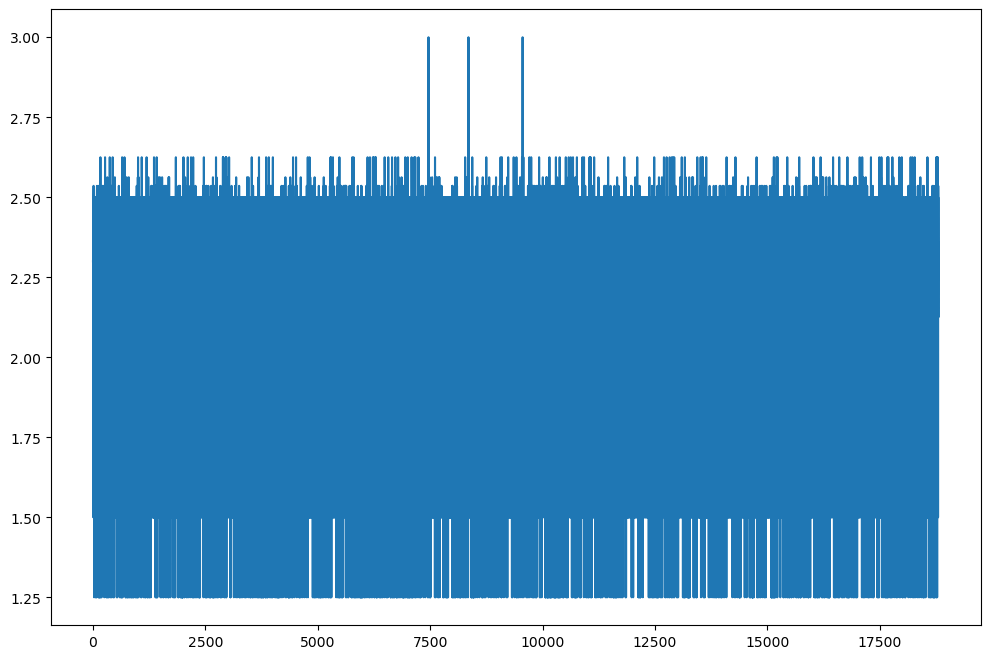

In [119]:
train_df['avg_area_flood_score'].plot(figsize=(12,8))

In [123]:
fsm_df = train_df[["avg_area_flood_score", "price"]].copy()
fsm_df.dropna(inplace=True)
formula = 'avg_area_flood_score ~ price'
fsm = ols(formula=formula, data=fsm_df).fit()

In [124]:
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     avg_area_flood_score   R-squared:                       0.007
Model:                              OLS   Adj. R-squared:                  0.007
Method:                   Least Squares   F-statistic:                     141.1
Date:                  Thu, 01 Jun 2023   Prob (F-statistic):           2.02e-32
Time:                          16:31:19   Log-Likelihood:                -8900.7
No. Observations:                 18805   AIC:                         1.781e+04
Df Residuals:                     18803   BIC:                         1.782e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1424      0.006    355.364      0.000       2.131       2.154
price      -6.403e-08   5.39e-09    -11.878      0.000   -7.46e-08   -5.35e-08
==============================================================================
Omnibus:                     2819.940   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1904.325
Skew:                          -0.667   Prob(JB):                         0.00
Kurtosis:                       2.192   Cond. No.                     2.38e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [126]:
test_df.perdict()

AttributeError: 'DataFrame' object has no attribute 'perdict'

## ---------------------------------------------------------------------------------------------------------------

In [205]:
# here we are going to create two data frames. The data frames will focus on three topics. city, bathrooms,
# and price. The first city will be one with water front properties. The second will be a city
# bordering the water front city. Then we will check the change in price of homes when both cities gain 
# patio space. Then we will check then change in price of homes in the non water front properites if 
# the water front properties become the new atlantis aka flood and disappear. 

In [206]:
neighborhood_df

,sqft_living,sqft_lot,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,street address,city,...,bathrooms_9.5,bathrooms_10.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,floors_4.0,coord,neighborhood
0,1979,13439,280,280,1963,0,47.281065,-122.298820,35770 27th Avenue South,Federal Way,...,0,0,0,0,0,0,0,0,"(47.28106500000001, -122.29882)",Lakeland South
1,2450,8772,460,460,2021,0,47.192910,-121.980870,243 Hogan Dr,Enumclaw,...,0,0,0,1,0,0,0,0,"(47.19291, -121.98087)",Enumclaw
2,1100,3000,0,0,1911,0,47.673490,-122.323730,6045 5th Avenue Northeast,Seattle,...,0,0,0,0,0,0,0,0,"(47.67349, -122.32373)",Seattle
3,3800,10194,580,0,1975,2006,47.532310,-122.226250,7815 85th Place Southeast,Mercer Island,...,0,0,0,0,0,0,0,0,"(47.53231, -122.22625)",Mercer Island
4,3840,15347,580,690,1976,0,47.382170,-122.150270,14327 Southeast 243rd Street,Kent,...,0,0,0,0,0,0,0,0,"(47.38217, -122.15027)",East Hill-Meridian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8664,2050,6250,330,60,1940,0,47.568830,-122.402505,3916 55th Avenue Southwest,Seattle,...,0,0,0,0,0,0,0,0,"(47.56883, -122.402505)",White Center
8665,2150,1342,380,530,2021,0,47.593319,-122.294430,1101 Yakima Avenue South,Seattle,...,0,0,0,0,0,1,0,0,"(47.593319, -122.29443)",Seattle
8666,2560,4116,510,260,2021,0,47.359860,-122.026100,27016 235th Place Southeast,Maple Valley,...,0,0,0,1,0,0,0,0,"(47.35986, -122.0261)",Maple Valley
8667,2560,4547,410,170,2022,0,47.359710,-122.076180,27018 199th Avenue Southeast,Covington,...,0,0,0,1,0,0,0,0,"(47.35971, -122.07618)",Lake Morton-Berrydale


In [207]:
neighborhood_df.columns

Index(['sqft_living', 'sqft_lot', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'lat', 'long', 'street address', 'city', 'zipcode',
       'floodzones_in_zipcode', 'area_flood_score_max', 'area_flood_score_min',
       'avg_area_flood_score', 'price', 'condition score', 'grade score_3',
       'grade score_4', 'grade score_5', 'grade score_6', 'grade score_7',
       'grade score_8', 'grade score_9', 'grade score_10', 'grade score_11',
       'grade score_12', 'grade score_13', 'has_basement_1', 'on_waterfront_1',
       'near_greenbelt_1', 'view score_1', 'view score_2', 'view score_3',
       'view score_4', 'nuisance_1', 'bedrooms_1', 'bedrooms_2', 'bedrooms_3',
       'bedrooms_4', 'bedrooms_5', 'bedrooms_6', 'bedrooms_7', 'bedrooms_8',
       'bedrooms_9', 'bedrooms_10', 'bathrooms_0.5', 'bathrooms_1.0',
       'bathrooms_1.5', 'bathrooms_2.0', 'bathrooms_2.5', 'bathrooms_3.0',
       'bathrooms_3.5', 'bathrooms_4.0', 'bathrooms_4.5', 'bathrooms_5.0',
       'bat

In [208]:
neighborhood_df['city'].value_counts()

Seattle             2754
Renton               569
Kent                 471
Auburn               433
Bellevue             413
Kirkland             366
Federal Way          356
Sammamish            323
Redmond              317
Maple Valley         281
Shoreline            252
Burien               203
Woodinville          168
Issaquah             160
Covington            151
Des Moines           148
North Bend           141
Enumclaw             137
Kenmore              109
Mercer Island         96
Snoqualmie            94
Bothell               77
Black Diamond         75
Duvall                72
SeaTac                71
Vashon                68
Newcastle             56
Lake Forest Park      52
Tukwila               51
Carnation             46
Normandy Park         31
Fall City             30
Pacific               23
Ravensdale            22
Clyde Hill            15
Algona                10
Skykomish              9
Medina                 8
Yarrow Point           3
Milton                 2


In [209]:
# picking a zip code in king county that is on the water
waterfront_df = neighborhood_df.loc[neighborhood_df['city'] == 'Renton']
waterfront_df

,sqft_living,sqft_lot,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,street address,city,...,bathrooms_9.5,bathrooms_10.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,floors_4.0,coord,neighborhood
10,2180,8664,740,900,1987,0,47.461935,-122.151065,13951 Southeast 156th Street,Renton,...,0,0,0,1,0,0,0,0,"(47.461935, -122.151065)",Fairwood
16,3040,8738,440,150,2019,0,47.472460,-122.126630,14439 160th Court Southeast,Renton,...,0,0,0,1,0,0,0,0,"(47.47246, -122.12663)",East Renton Highlands
26,1480,8369,440,500,1980,0,47.463980,-122.184870,Edmonds Court Southeast,Renton,...,0,0,0,0,0,0,0,0,"(47.46398, -122.18487)",Fairwood
27,2570,6306,530,370,1965,2008,47.471930,-122.200010,1307 South 9th Street,Renton,...,0,0,0,0,0,0,0,0,"(47.47193, -122.20001)",Renton
46,2600,24200,650,180,1961,0,47.457640,-122.085630,19047 Southeast 161st Street,Renton,...,0,0,0,0,0,0,0,0,"(47.45764000000001, -122.08563)",Maple Heights-Lake Desire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8570,2120,7131,400,60,2012,0,47.441145,-122.160365,18007 135th Place Southeast,Renton,...,0,0,0,1,0,0,0,0,"(47.441145, -122.16036499999998)",Fairwood
8580,1960,7825,640,210,2005,0,47.482315,-122.144290,5605 Southeast 1st Place,Renton,...,0,0,0,1,0,0,0,0,"(47.482315, -122.14428999999998)",East Renton Highlands
8584,3322,4781,399,161,2019,0,47.436990,-122.154930,18436 139th Way Southeast,Renton,...,0,0,0,1,0,0,0,0,"(47.43699, -122.15493)",Fairwood
8603,1890,10452,0,610,1967,0,47.482510,-122.125705,16033 Southeast 134th Street,Renton,...,0,0,0,0,0,0,0,0,"(47.48251, -122.125705)",East Renton Highlands


In [210]:
# picking a zip code in king county that is right above/behind a water front zip code 
non_waterfront_df = neighborhood_df.loc[neighborhood_df['city'] == 'Kent']
non_waterfront_df

,sqft_living,sqft_lot,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,street address,city,...,bathrooms_9.5,bathrooms_10.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,floors_4.0,coord,neighborhood
4,3840,15347,580,690,1976,0,47.382170,-122.150270,14327 Southeast 243rd Street,Kent,...,0,0,0,0,0,0,0,0,"(47.38217, -122.15027)",East Hill-Meridian
41,2480,7725,400,410,1959,0,47.388940,-122.220400,811 Alvord Avenue North,Kent,...,0,0,0,0,0,0,0,0,"(47.38894000000001, -122.2204)",Kent
90,1480,54450,0,80,1956,0,47.420980,-122.151500,20210 142nd Avenue Southeast,Kent,...,0,0,0,0,0,0,0,0,"(47.42098, -122.1515)",East Hill-Meridian
126,2080,9605,680,540,1993,0,47.384790,-122.212860,9529 South 242nd Street,Kent,...,0,0,0,1,0,0,0,0,"(47.38479, -122.21286)",Kent
136,2050,7200,580,120,1977,0,47.396890,-122.173880,22825 126th Place Southeast,Kent,...,0,0,0,0,0,0,0,0,"(47.39689, -122.17388)",East Hill-Meridian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8606,1832,9608,0,464,1965,0,47.410600,-122.209055,9821 South 213th Place,Kent,...,0,0,0,0,0,0,0,0,"(47.4106, -122.209055)",East Hill-Meridian
8618,4210,17061,1290,430,1978,0,47.382855,-122.161230,24330 135th Avenue Southeast,Kent,...,0,0,0,0,0,0,0,0,"(47.382855, -122.16123)",East Hill-Meridian
8636,1860,101059,570,500,1978,0,47.383900,-122.115890,24308 168th Avenue Southeast,Kent,...,0,0,0,0,0,0,0,0,"(47.3839, -122.11589)",Covington
8652,1070,3067495,300,0,1959,0,47.369970,-122.261620,25095 Frager Road South,Kent,...,0,0,0,0,0,0,0,0,"(47.36997, -122.26162)",Kent


In [211]:
waterfront_df["city"].value_counts()

Renton              569
Algona                0
Auburn                0
Mercer Island         0
Milton                0
Newcastle             0
Normandy Park         0
North Bend            0
Pacific               0
Ravensdale            0
Redmond               0
Sammamish             0
SeaTac                0
Seattle               0
Shoreline             0
Skykomish             0
Snoqualmie            0
Snoqualmie Pass       0
Tukwila               0
Vashon                0
Woodinville           0
Medina                0
Maple Valley          0
Lake Forest Park      0
Covington             0
Baring                0
Beaux Arts            0
Bellevue              0
Black Diamond         0
Bothell               0
Burien                0
Carnation             0
Clyde Hill            0
Des Moines            0
Kirkland              0
Duvall                0
Enumclaw              0
Fall City             0
Federal Way           0
Hobart                0
Issaquah              0
Kenmore         

In [212]:
non_waterfront_df["city"].value_counts()

Kent                471
Algona                0
Medina                0
Milton                0
Newcastle             0
Normandy Park         0
North Bend            0
Pacific               0
Ravensdale            0
Redmond               0
Renton                0
Sammamish             0
SeaTac                0
Seattle               0
Shoreline             0
Skykomish             0
Snoqualmie            0
Snoqualmie Pass       0
Tukwila               0
Vashon                0
Woodinville           0
Mercer Island         0
Maple Valley          0
Auburn                0
Covington             0
Baring                0
Beaux Arts            0
Bellevue              0
Black Diamond         0
Bothell               0
Burien                0
Carnation             0
Clyde Hill            0
Des Moines            0
Lake Forest Park      0
Duvall                0
Enumclaw              0
Fall City             0
Federal Way           0
Hobart                0
Issaquah              0
Kenmore         

In [213]:
# here we are going to check to make sure there are no matching street addresses for our two daraframes ensuring 
# all values are in seperate zip codes
# Check for matching values
matching_values = non_waterfront_df['street address'].isin(waterfront_df['street address'])
non_matching_values = ~matching_values

# Retrieve rows with non-matching values
non_matching_rows = non_waterfront_df[non_matching_values]

# Check if any matching value exists
matching_exists = matching_values.any()

# Print the results
if matching_exists:
    print("There are matching values.")
else:
    print("No matching values found.")

No matching values found.


In [214]:
# no matching values were found. This ensures we have no duplicate data.

In [215]:
# lets take the non water front city Kent, and see the change in home value when a bathroom is added to the homes. 
non_waterfront_df.describe()

,sqft_living,sqft_lot,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,zipcode,area_flood_score_max,...,bathrooms_7.0,bathrooms_7.5,bathrooms_9.5,bathrooms_10.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,floors_4.0
count,471.000000,4.710000e+02,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,...,471.0,471.0,471.0,471.0,471.000000,471.000000,471.000000,471.0,471.0,471.0
mean,2103.602972,2.484065e+04,444.488323,192.938429,1982.709130,29.594480,47.377743,-122.178907,98034.435244,2.527020,...,0.0,0.0,0.0,0.0,0.059448,0.424628,0.006369,0.0,0.0,0.0
std,719.949793,1.479314e+05,242.975656,210.939636,21.214064,241.235197,0.025268,0.051144,5.405626,0.189066,...,0.0,0.0,0.0,0.0,0.236713,0.494812,0.079639,0.0,0.0,0.0
min,720.000000,1.561000e+03,0.000000,0.000000,1908.000000,0.000000,47.306985,-122.307015,98030.000000,2.250000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,1598.500000,6.807500e+03,390.000000,40.000000,1967.500000,0.000000,47.359988,-122.206270,98030.000000,2.250000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,1982.000000,8.360000e+03,460.000000,140.000000,1981.000000,0.000000,47.377075,-122.179445,98031.000000,2.666667,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
75%,2555.000000,1.205200e+04,550.000000,280.000000,1997.000000,0.000000,47.396637,-122.155455,98042.000000,2.666667,...,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.0
max,6430.000000,3.067495e+06,2530.000000,1686.000000,2022.000000,2020.000000,47.429970,-122.047780,98058.000000,2.666667,...,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,0.0,0.0


In [216]:
#checking the average price of homes that do not have a patio
non_patio_df = non_waterfront_df.loc[neighborhood_df['sqft_patio'] == 0]
non_patio_df[['price']].describe().applymap(lambda x: f"{x:0.3f}")

,price
count,96.000
mean,616624.115
std,227812.383
min,175000.000
25%,500000.000
50%,575000.000
75%,680000.000
max,2100000.000


<Axes: xlabel='price'>

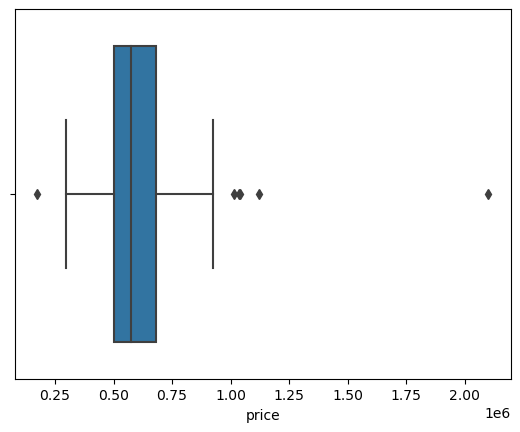

In [217]:
sns.boxplot(x=non_patio_df['price'])

In [218]:
#checking the average price of homes that do have a patio
patio_df = non_waterfront_df.loc[neighborhood_df['sqft_patio'] > 1]
patio_df[['price']].describe().applymap(lambda x: f"{x:0.3f}")

,price
count,375.000
mean,672199.133
std,192415.945
min,64559.000
25%,551500.000
50%,660950.000
75%,785000.000
max,1900000.000


<Axes: xlabel='price'>

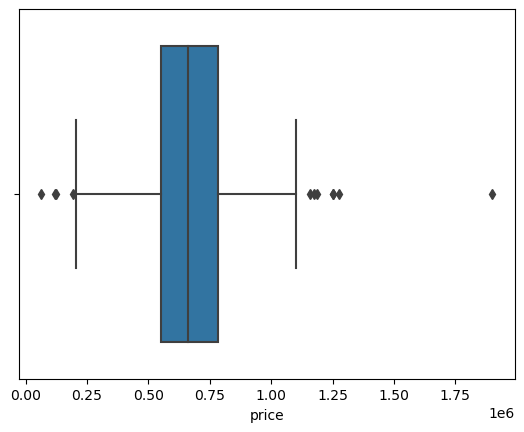

In [219]:
sns.boxplot(x=patio_df['price'])

<Axes: xlabel='price', ylabel='city'>

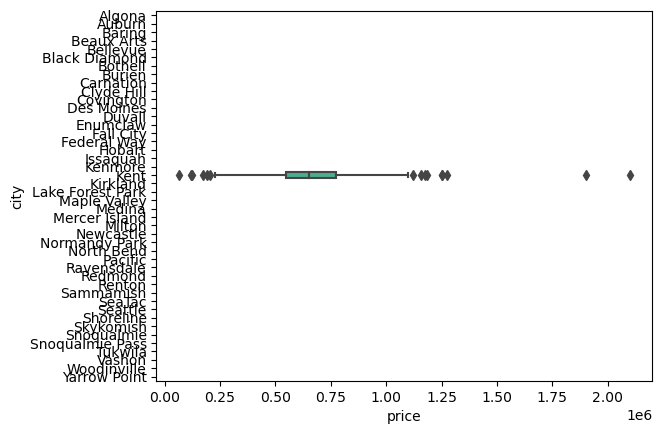

In [220]:
sns.boxplot(data=non_waterfront_df, x="price", y='city')

In [221]:
# the two mean differnces are 672199.133 - 616624.115. having any patio can increase the home value by a 
# mean of 55575.018. Let create a new column for the adjusted home price with the added patio

In [222]:
# Create a new column 'price_changed' with the initial values from 'price' column
non_waterfront_df['price_changed'] = non_waterfront_df['price']

# Check for rows where 'sqft_patio' is equal to zero
zero_rows = non_waterfront_df['sqft_patio'] == 0

# Add 55575.018 to 'price_changed' column for those rows
non_waterfront_df.loc[zero_rows, 'price_changed'] += 55575.018

In [223]:
non_waterfront_df[['price']].describe().applymap(lambda x: f"{x:0.3f}")

,price
count,471.000
mean,660871.741
std,201131.707
min,64559.000
25%,547475.000
50%,650000.000
75%,775000.000
max,2100000.000


In [225]:
non_waterfront_df[['price_changed']].describe().applymap(lambda x: f"{x:0.3f}")

,price_changed
count,471.000
mean,672199.133
std,199879.181
min,64559.000
25%,555000.000
50%,653500.000
75%,775000.000
max,2155575.018


In [224]:
non_waterfront_df[['sqft_patio']].describe().applymap(lambda x: f"{x:0.3f}")

,sqft_patio
count,471.000
mean,192.938
std,210.940
min,0.000
25%,40.000
50%,140.000
75%,280.000
max,1686.000


In [228]:
# adding 192.938 to all the sqft_patio values that equal zero to mathc the mean price incerease

non_waterfront_df.loc[non_waterfront_df['sqft_patio'] == 0, 'sqft_patio'] += 192.938
non_waterfront_df.head()

,sqft_living,sqft_lot,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,street address,city,...,bathrooms_10.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,floors_4.0,coord,neighborhood,price_changed
4,3840,15347,580,690.0,1976,0,47.38217,-122.15027,14327 Southeast 243rd Street,Kent,...,0,0,0,0,0,0,0,"(47.38217, -122.15027)",East Hill-Meridian,900000.0
41,2480,7725,400,410.0,1959,0,47.38894,-122.22040,811 Alvord Avenue North,Kent,...,0,0,0,0,0,0,0,"(47.38894000000001, -122.2204)",Kent,550000.0
90,1480,54450,0,80.0,1956,0,47.42098,-122.15150,20210 142nd Avenue Southeast,Kent,...,0,0,0,0,0,0,0,"(47.42098, -122.1515)",East Hill-Meridian,800000.0
126,2080,9605,680,540.0,1993,0,47.38479,-122.21286,9529 South 242nd Street,Kent,...,0,0,1,0,0,0,0,"(47.38479, -122.21286)",Kent,650000.0
136,2050,7200,580,120.0,1977,0,47.39689,-122.17388,22825 126th Place Southeast,Kent,...,0,0,0,0,0,0,0,"(47.39689, -122.17388)",East Hill-Meridian,675000.0


In [237]:
X_train = np.array(non_waterfront_df['sqft_patio']).reshape(-1, 1)
y_train = non_waterfront_df['price_changed']
X_train

array([[ 690.   ],
       [ 410.   ],
       [  80.   ],
       [ 540.   ],
       [ 120.   ],
       [ 144.   ],
       [1170.   ],
       [ 240.   ],
       [  50.   ],
       [ 190.   ],
       [ 160.   ],
       [ 100.   ],
       [ 192.938],
       [  20.   ],
       [ 220.   ],
       [ 340.   ],
       [ 130.   ],
       [ 310.   ],
       [ 110.   ],
       [ 190.   ],
       [  80.   ],
       [ 500.   ],
       [ 125.   ],
       [ 140.   ],
       [ 340.   ],
       [ 192.938],
       [ 840.   ],
       [ 130.   ],
       [ 100.   ],
       [ 290.   ],
       [ 200.   ],
       [  30.   ],
       [  44.   ],
       [ 230.   ],
       [ 110.   ],
       [ 304.   ],
       [ 192.938],
       [ 240.   ],
       [ 192.938],
       [ 260.   ],
       [  80.   ],
       [ 300.   ],
       [ 192.938],
       [ 890.   ],
       [ 192.938],
       [ 390.   ],
       [ 160.   ],
       [  80.   ],
       [ 192.938],
       [ 100.   ],
       [ 440.   ],
       [ 190.   ],
       [ 192

In [238]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          price_changed   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     16.16
Date:                Fri, 02 Jun 2023   Prob (F-statistic):           6.78e-05
Time:                        00:44:29   Log-Likelihood:                -6408.6
No. Observations:                 471   AIC:                         1.282e+04
Df Residuals:                     469   BIC:                         1.283e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.271e+05   1.44e+04     43.498      0.000    5.99e+05    6.55e+05
x1           194.0478     48.270      4.020      0.000      99.196     288.900
==============================================================================
Omnibus:                      194.645   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2050.202
Skew:                           1.485   Prob(JB):                         0.00
Kurtosis:                      12.780   Cond. No.                         475.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [239]:
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

# Evaluate using rmse
scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)

In [240]:
rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([171416.00751811, 168101.67371634, 168216.43415627, 267218.20343847,
       153269.57379721, 190261.32530264, 170752.2328823 , 151171.24873152,
       191601.5819986 , 286555.3250957 ])

191856.36066371505

44475.22033431774

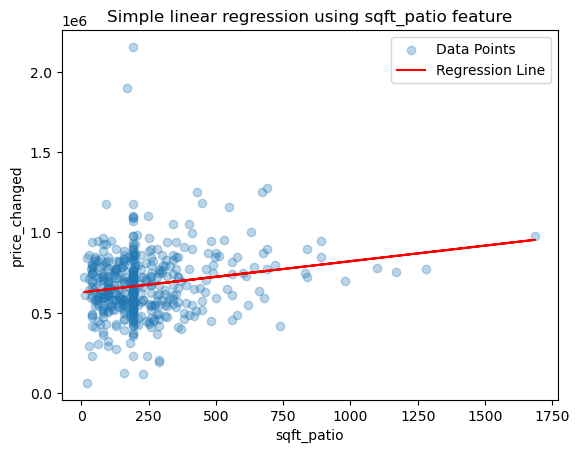

In [243]:
y_pred = linreg.predict(X_train)
# Plot data points
plt.scatter(x = X_train[:2000], y = y_train[:2000], alpha = 0.3, label = 'Data Points')
# Plot regression line
plt.plot(X_train, y_pred, color = 'red', label = 'Regression Line')
plt.legend()
plt.title('Simple linear regression using sqft_patio feature')
plt.xlabel('sqft_patio')
plt.ylabel('price_changed')
plt.show()

In [ ]:
# now what would happen if the water front city sank? We added a patio and
# that dramatically ncreased the price? What if the city in front of it sank from a flood?


In [254]:
waterfront_df[['price']].describe().applymap(lambda x: f"{x:0.3f}")

,price
count,569.000
mean,800445.327
std,343745.707
min,90000.000
25%,592000.000
50%,734000.000
75%,910000.000
max,2950000.000


In [256]:
non_waterfront_df[['price_changed']].describe().applymap(lambda x: f"{x:0.3f}")

,price_changed
count,471.000
mean,672199.133
std,199879.181
min,64559.000
25%,555000.000
50%,653500.000
75%,775000.000
max,2155575.018


In [258]:
non_waterfront_df[['price']].describe().applymap(lambda x: f"{x:0.3f}")

,price
count,471.000
mean,660871.741
std,201131.707
min,64559.000
25%,547475.000
50%,650000.000
75%,775000.000
max,2100000.000


In [264]:
# the mean price difference between waterfront and non waterfront is 800445.327 - 660871.741 = 139573.586. we 
# can add this value to our new column price_changed_WF ,, WF for waterfront. But how significant is the 
# flood score of out city below the waves? is it likely to sink at all? lets check.
waterfront_df.head()

,sqft_living,sqft_lot,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,street address,city,...,bathrooms_9.5,bathrooms_10.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,floors_4.0,coord,neighborhood
10,2180,8664,740,900,1987,0,47.461935,-122.151065,13951 Southeast 156th Street,Renton,...,0,0,0,1,0,0,0,0,"(47.461935, -122.151065)",Fairwood
16,3040,8738,440,150,2019,0,47.472460,-122.126630,14439 160th Court Southeast,Renton,...,0,0,0,1,0,0,0,0,"(47.47246, -122.12663)",East Renton Highlands
26,1480,8369,440,500,1980,0,47.463980,-122.184870,Edmonds Court Southeast,Renton,...,0,0,0,0,0,0,0,0,"(47.46398, -122.18487)",Fairwood
27,2570,6306,530,370,1965,2008,47.471930,-122.200010,1307 South 9th Street,Renton,...,0,0,0,0,0,0,0,0,"(47.47193, -122.20001)",Renton
46,2600,24200,650,180,1961,0,47.457640,-122.085630,19047 Southeast 161st Street,Renton,...,0,0,0,0,0,0,0,0,"(47.45764000000001, -122.08563)",Maple Heights-Lake Desire


In [265]:
waterfront_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 10 to 8641
Data columns (total 71 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   sqft_living            569 non-null    int64   
 1   sqft_lot               569 non-null    int64   
 2   sqft_garage            569 non-null    int64   
 3   sqft_patio             569 non-null    int64   
 4   yr_built               569 non-null    int64   
 5   yr_renovated           569 non-null    int64   
 6   lat                    569 non-null    float64 
 7   long                   569 non-null    float64 
 8   street address         569 non-null    category
 9   city                   569 non-null    category
 10  zipcode                569 non-null    int64   
 11  floodzones_in_zipcode  569 non-null    category
 12  area_flood_score_max   569 non-null    float64 
 13  area_flood_score_min   569 non-null    float64 
 14  avg_area_flood_score   569 non-null    f

In [280]:
X = waterfront_df[['on_waterfront_1', 'price', 'yr_built', 'yr_renovated', 'sqft_patio', 'sqft_garage', 'sqft_lot', 'sqft_living', 'condition score', 'yr_built', 'area_flood_score_min']]
y = waterfront_df['avg_area_flood_score'] 
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())      
                       
                       

                             OLS Regression Results                             
Dep. Variable:     avg_area_flood_score   R-squared:                       0.954
Model:                              OLS   Adj. R-squared:                  0.953
Method:                   Least Squares   F-statistic:                     1151.
Date:                  Fri, 02 Jun 2023   Prob (F-statistic):               0.00
Time:                          02:27:49   Log-Likelihood:                 851.46
No. Observations:                   569   AIC:                            -1681.
Df Residuals:                       558   BIC:                            -1633.
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const       

In [281]:
# we took the min and not the max flood score because we can assume the city will recive the minimum
# amount of flooding. Lets add the difference of the min flood score to the average flood score to see what a 
# future flood score will look like

In [284]:
waterfront_df['avg_area_flood_score'].describe()

count    569.000000
mean       2.207653
std        0.252202
min        1.833333
25%        1.833333
50%        2.357143
75%        2.357143
max        2.500000
Name: avg_area_flood_score, dtype: float64

In [286]:
2.207653 - 2.063436

0.14421700000000026

In [287]:
2.207653 + 0.144217

2.35187

In [288]:
waterfront_df['future_flood_score'] = waterfront_df['avg_area_flood_score'] + 0.144217

In [289]:
waterfront_df.describe()

,sqft_living,sqft_lot,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,zipcode,area_flood_score_max,...,bathrooms_7.5,bathrooms_9.5,bathrooms_10.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,floors_4.0,future_flood_score
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.0,569.0,569.0,569.000000,569.000000,569.0,569.000000,569.0,569.0,569.000000
mean,2065.780316,14281.101933,393.706503,192.265378,1978.017575,63.448155,47.473072,-122.159982,98057.521968,2.351870,...,0.0,0.0,0.0,0.045694,0.421793,0.0,0.001757,0.0,0.0,2.351870
std,784.597393,26409.890027,243.831447,203.359872,25.630769,351.365858,0.027812,0.036552,1.354424,0.236565,...,0.0,0.0,0.0,0.209005,0.494280,0.0,0.041922,0.0,0.0,0.252202
min,460.000000,855.000000,0.000000,0.000000,1900.000000,0.000000,47.409310,-122.230950,98055.000000,2.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.977550
25%,1500.000000,6000.000000,280.000000,40.000000,1961.000000,0.000000,47.450930,-122.188810,98056.000000,2.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.977550
50%,1960.000000,7989.000000,440.000000,130.000000,1978.000000,0.000000,47.474980,-122.163640,98058.000000,2.428571,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,2.501360
75%,2525.000000,11186.000000,540.000000,270.000000,2001.000000,0.000000,47.492350,-122.135240,98059.000000,2.500000,...,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0,2.501360
max,5390.000000,243936.000000,1300.000000,1240.000000,2021.000000,2022.000000,47.540930,-122.060050,98059.000000,2.666667,...,0.0,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.0,0.0,2.644217


In [293]:
# lets run our test again

X = waterfront_df[['on_waterfront_1', 'price', 'yr_built', 'yr_renovated', 'sqft_patio', 'sqft_garage', 'sqft_lot', 'sqft_living', 'condition score', 'yr_built', 'area_flood_score_min']]
y = waterfront_df['future_flood_score'] 
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())   

                            OLS Regression Results                            
Dep. Variable:     future_flood_score   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     1151.
Date:                Fri, 02 Jun 2023   Prob (F-statistic):               0.00
Time:                        02:40:24   Log-Likelihood:                 851.46
No. Observations:                 569   AIC:                            -1681.
Df Residuals:                     558   BIC:                            -1633.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1698 

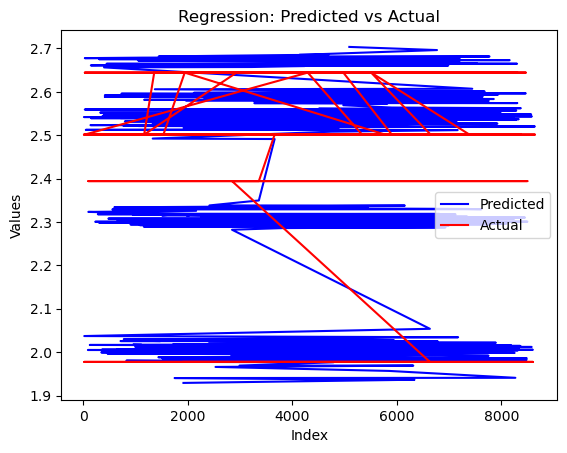

In [296]:
# Sort the actual values and predicted values based on the predicted values
sorted_values = pd.DataFrame({'Actual': y, 'Predicted': results.fittedvalues}).sort_values(by='Predicted')

# Create a line plot of the sorted values
plt.plot(sorted_values['Predicted'], 'b-', label='Predicted')
plt.plot(sorted_values['Actual'], 'r-', label='Actual')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Regression: Predicted vs Actual')
plt.legend()
plt.show()

In [295]:
# looks like its a safe bet that its sinking in the future. Lets go back to our previous question.
# the mean price difference between waterfront and non waterfront is 800445.327 - 660871.741 = 139573.586. we 
# can add this value to our new column price_changed_WF ,, WF for waterfront. 
non_waterfront_df.head()

,sqft_living,sqft_lot,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,street address,city,...,bathrooms_10.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,floors_4.0,coord,neighborhood,price_changed
4,3840,15347,580,690.0,1976,0,47.38217,-122.15027,14327 Southeast 243rd Street,Kent,...,0,0,0,0,0,0,0,"(47.38217, -122.15027)",East Hill-Meridian,900000.0
41,2480,7725,400,410.0,1959,0,47.38894,-122.22040,811 Alvord Avenue North,Kent,...,0,0,0,0,0,0,0,"(47.38894000000001, -122.2204)",Kent,550000.0
90,1480,54450,0,80.0,1956,0,47.42098,-122.15150,20210 142nd Avenue Southeast,Kent,...,0,0,0,0,0,0,0,"(47.42098, -122.1515)",East Hill-Meridian,800000.0
126,2080,9605,680,540.0,1993,0,47.38479,-122.21286,9529 South 242nd Street,Kent,...,0,0,1,0,0,0,0,"(47.38479, -122.21286)",Kent,650000.0
136,2050,7200,580,120.0,1977,0,47.39689,-122.17388,22825 126th Place Southeast,Kent,...,0,0,0,0,0,0,0,"(47.39689, -122.17388)",East Hill-Meridian,675000.0


In [298]:
non_waterfront_df['flood_prices'] = non_waterfront_df['price_changed'] + 139573.586
non_waterfront_df

,sqft_living,sqft_lot,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,street address,city,...,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,floors_4.0,coord,neighborhood,price_changed,flood_prices
4,3840,15347,580,690.000,1976,0,47.382170,-122.150270,14327 Southeast 243rd Street,Kent,...,0,0,0,0,0,0,"(47.38217, -122.15027)",East Hill-Meridian,900000.000,1039573.586
41,2480,7725,400,410.000,1959,0,47.388940,-122.220400,811 Alvord Avenue North,Kent,...,0,0,0,0,0,0,"(47.38894000000001, -122.2204)",Kent,550000.000,689573.586
90,1480,54450,0,80.000,1956,0,47.420980,-122.151500,20210 142nd Avenue Southeast,Kent,...,0,0,0,0,0,0,"(47.42098, -122.1515)",East Hill-Meridian,800000.000,939573.586
126,2080,9605,680,540.000,1993,0,47.384790,-122.212860,9529 South 242nd Street,Kent,...,0,1,0,0,0,0,"(47.38479, -122.21286)",Kent,650000.000,789573.586
136,2050,7200,580,120.000,1977,0,47.396890,-122.173880,22825 126th Place Southeast,Kent,...,0,0,0,0,0,0,"(47.39689, -122.17388)",East Hill-Meridian,675000.000,814573.586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8606,1832,9608,0,464.000,1965,0,47.410600,-122.209055,9821 South 213th Place,Kent,...,0,0,0,0,0,0,"(47.4106, -122.209055)",East Hill-Meridian,775000.000,914573.586
8618,4210,17061,1290,430.000,1978,0,47.382855,-122.161230,24330 135th Avenue Southeast,Kent,...,0,0,0,0,0,0,"(47.382855, -122.16123)",East Hill-Meridian,1250000.000,1389573.586
8636,1860,101059,570,500.000,1978,0,47.383900,-122.115890,24308 168th Avenue Southeast,Kent,...,0,0,0,0,0,0,"(47.3839, -122.11589)",Covington,870000.000,1009573.586
8652,1070,3067495,300,192.938,1959,0,47.369970,-122.261620,25095 Frager Road South,Kent,...,0,0,0,0,0,0,"(47.36997, -122.26162)",Kent,2155575.018,2295148.604


In [300]:

X = non_waterfront_df[['on_waterfront_1', 'price', 'yr_built', 'yr_renovated', 'sqft_patio', 'sqft_garage', 'sqft_lot', 'sqft_living', 'condition score', 'yr_built']]
y = non_waterfront_df['flood_prices'] 
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())   

                            OLS Regression Results                            
Dep. Variable:           flood_prices   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     4427.
Date:                Fri, 02 Jun 2023   Prob (F-statistic):               0.00
Time:                        02:48:21   Log-Likelihood:                -5363.7
No. Observations:                 471   AIC:                         1.075e+04
Df Residuals:                     461   BIC:                         1.079e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4.264e+05    1.2e+05     

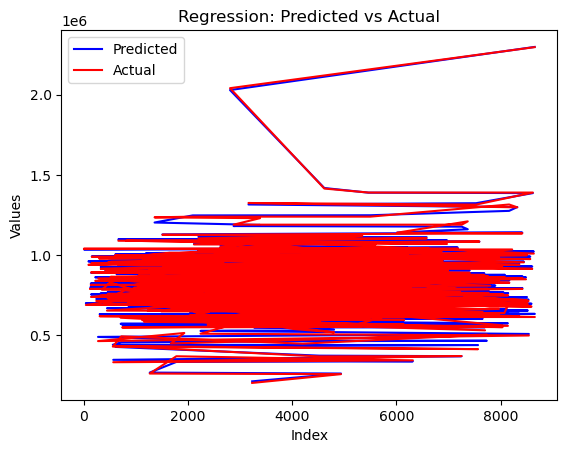

In [301]:
# Sort the actual values and predicted values based on the predicted values
sorted_values = pd.DataFrame({'Actual': y, 'Predicted': results.fittedvalues}).sort_values(by='Predicted')

# Create a line plot of the sorted values
plt.plot(sorted_values['Predicted'], 'b-', label='Predicted')
plt.plot(sorted_values['Actual'], 'r-', label='Actual')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Regression: Predicted vs Actual')
plt.legend()
plt.show()

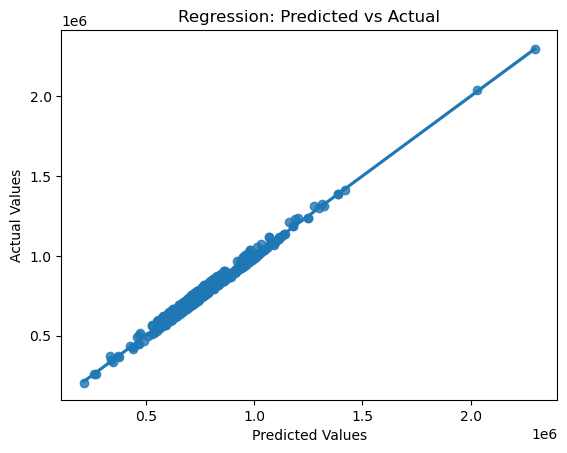

In [302]:
sns.regplot(x=results.fittedvalues, y=y)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Regression: Predicted vs Actual')
plt.show()

In [303]:
# the mapping shows that if in the future there is a flood, the value of the non water front homes will increase 